In [1]:
!pip install wandb --upgrade
!pip install keras

     |████████████████████████████████| 1.7 MB 14.1 MB/s 
     |████████████████████████████████| 97 kB 5.6 MB/s 
     |████████████████████████████████| 139 kB 57.6 MB/s 
     |████████████████████████████████| 180 kB 84.4 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=14c828815d10a767e1bd7860bdbcfcdf3fe8018d4a05a9faa17155c501effced
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=ba5bfc6bc3f52a900b0be0c5ed02bb55bd34e41539a0c3b5f6f6e83f9a5e70d5
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [1]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Importing relevant libraries
import wandb
import numpy as np
from tqdm.auto import tqdm
import pprint
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from skimage.feature import hog
from sklearn import metrics
import seaborn as sns
import pandas as pd
from scipy.special import softmax as smax

In [4]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [3]:
%%capture
# Logging into wandb to log the models we train for reference
wandb.login(key='19838da47619a19885f247f0e4dc5fb5d32683d2', force=True)
# wandb.init(project='EE6132_Lab1', entity='ani_r')

# Data Loading

In [4]:
def loadMNIST(val_samples=10000, return_images=False, is_val_split=False, seed_value=0):
    '''
    ################
    Function which returns a dictionary containing the shuffled version of the MNIST dataset.
    Arguments:
    val_samples     [int]   Number of validation samples to take out of the training set of 60K samples     (default: 10K)
    return_images   [bool]  Whether we need to return images            (default: False)
                                True: returns images
                                False: returns flattened vectors
    is_val_split    [bool]  Whether validation split needs to be done   (default: False)
                                True: returns train(60K-val_samples), validation(val_samples) and test(10K)
                                False: returns train(60K) and test(10K)
    seed            [int]   Seed value for the numpy random shuffling   (default: 0)
    ########
    Return:
    Dictionary containing the numpy arrays corresponding to train, test and val(if is_val_split==True)
                    dict:   train:  X
                                    y
                            test:   X
                                    y
                            val:    X           (if is_val_split == True)
                                    y           (if is_val_split == True)
    ################
    '''

    # Loading MNIST data onto numpy arrays
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

    # Shuffling data
    np.random.seed(seed_value)
    train_shuffler = np.random.permutation(60000)
    x_train, y_train = x_train[train_shuffler], y_train[train_shuffler]
    test_shuffler = np.random.permutation(10000)
    x_test, y_test = x_test[test_shuffler], y_test[test_shuffler]

    # Normalizing the input data
    x_train = np.array(x_train/255.0, dtype='float32')
    x_test = np.array(x_test/255.0, dtype='float32')

    ## Splitting data appropriately
    # Number of training samples 
    train_samples = 60000 - val_samples

    if is_val_split == True:
        # Splitting the train set into the new train and val sets
        x_train, x_val = x_train[:train_samples], x_train[train_samples:]
        y_train, y_val = y_train[:train_samples], y_train[train_samples:]

        # Flattening the 28x28 images into vectors and then returning
        if (return_images==False):
            return {
                'train':{
                    'X': x_train.reshape([train_samples, 784]),
                    'Y': y_train.reshape([train_samples])
                },
                'val':{
                    'X': x_val.reshape([val_samples, 784]),
                    'Y': y_val.reshape([val_samples])
                },
                'test':{
                    'X': x_test.reshape([10000, 784]),
                    'Y': y_test.reshape([10000])
                }
            }
        # Returning the 28x28 images as is
        else :
            return {
                'train':{
                    'X': x_train,
                    'Y': y_train
                },
                'val':{
                    'X': x_val,
                    'Y': y_val
                },
                'test':{
                    'X': x_test,
                    'Y': y_test
                }
            }
    # Training set is not split
    else:
        # Flattening the images and then returning
        if (return_images==False):
            return {
                'train':{
                    'X': x_train.reshape([60000, 784]),
                    'Y': y_train.reshape([60000])
                },
                'test':{
                    'X': x_test.reshape([10000, 784]),
                    'Y': y_test.reshape([10000])
                }
            }
        # Returning the images as is
        else :
            return {
                'train':{
                    'X': x_train,
                    'Y': y_train
                },
                'test':{
                    'X': x_test,
                    'Y': y_test
                }
            }


In [5]:
# Loading data as flattened vectors with no validation set
data = loadMNIST()

# Implementation of Multi Layer Perceptron(MLP)

In [7]:
class NeuralNetwork:
    '''
    Class to define the multi-layer perceptron and its related functions for training and testing
    '''

    # Constructor function - initializes weights, biases and sets the MLP structure
    def __init__(self, dict_layers, initializer):
        self.weights_list = []
        self.biases_list = []
        self.dict_layers= dict_layers
        self.weights_list, self.biases_list = wandb_initializer(dict_layers, self.weights_list, self.biases_list, initializer)

    def forwardProp(self, W, b, X, activation_func):
        '''
        This fuction implements forward propagation in the neural network
        Z       [Pre-Activation]    Obtained after weights and biases are applied on previous layer's outputs
        A       [Activation]        Output of current layer obtained after applying activation_func on Z
        
        Forward Propagation :
        For each hidden layer,
            Z_i = W_(i-1)*A_(i-1) + b_(i-1)
            A_i = activation_func(Z_i)

        For output layer,
            Z_last = W_last*A_(last hidden layer) + b_last
            Output(Y_hat) = softmax(Z_last)

        Returns :
        Output(Y_hat), Z, A(lists of all the pre-activations and activations respectively)
        '''

        # Initializing Z and A lists
        Z = []
        A = []
        
        # Output of input layer
        A_pre = X
        
        # Number of hidden layers
        L = self.dict_layers['num_hidden_layers']

        # Forward propogration through the hidden layers
        for i in range(L) :
            # Computing pre activation
            Z.append(W[i] @ A_pre + b[i])

            # Applying activation
            A_pre = getattr(activation, activation_func)(Z[i])
            A.append(A_pre)
    
        # Computing pre activation of last layer(output layer)
        Z.append(W[L] @ A_pre + b[L])
        
        # Computing outputs of MLP
        Y_hat = activation.softmax(Z[L])
        A.append(Y_hat)

        return {
            'Z' : Z,
            'A' : A,
            'Y_hat' : Y_hat
        }

    def backProp(self, W, b, Z, A, Y_hat, X, Y, activation_func):
        '''
        This function implements backpropogation
        
        Here, the implementation is based on cross-entropy loss(L) since this is a classification problem
        Equations:
        δL/δW_l = (δL/δZ_(l+1))(A_l)^T
        δL/δb_l = δL/δZ_(l+1)
        δL/δZ_l = (W_l)^T(δL/δZ_(l+1)) ⊙ f'(Z_l)

        Arguments:
        W               List of weights
        b               List of biases
        A               Activations from forward propagation
        Z               Pre-Activations from forward propagation
        Y_hat           Softmax output obtained during the forward pass
        X               Input data
        Y               True class labels
        activation_func Activation used in the hidden layers

        Returns: Dict containing
        δL/δW               del_w
        δL/δb               del_b
        inactive_neurons    Percentage of inactive neurons in each hidden layer as a dict
        '''

        # Batch size
        batch_size = len(Y)

        # Dict to store the percentage of inactive neurons in each hidden layer
        inactive_neurons = {}
        
        # Initializing gradient lists
        del_w = []
        del_b = []
        L = self.dict_layers['num_hidden_layers']
        
        # Converting ground truth outputs to one hot representation
        E = np.zeros(Y_hat.shape)
        E[Y, np.arange(batch_size)] = 1
        
        # Gradient(δL/δZ) calculation for final layer(based on cross-entropy loss)
        grad_Z = Y_hat - E

        # Iterating through layers from the last layer
        for i in range(L,-1,-1) :

            # Local gradient
            temp1 = grad_Z
            
            # temp2 contains the activation
            if i==0 :
                temp2 = X.T
            else :
                temp2 = A[i-1].T

            # Appending gradient vectors
            del_w.append(temp1 @ temp2/batch_size)
            del_b.append(grad_Z/batch_size)

            # Local gradient(grad_Z OR lowercase delta) propagating backwards
            if (i!=0):
                grad_Z = (W[i].T @ grad_Z) * getattr(activation,activation_func+'_der')(Z[i-1])
                temp = np.mean(grad_Z, axis=1)
                count = np.sum((temp<1e-5)*1)
                inactive_neurons['h%d'%(i)] = 100*(count/self.dict_layers['hidden_layer_size'][i-1])

        # Summing up the gradients corresponding to the various data points in the batch
        for j in range(len(del_b)) :
            del_b[j] = np.sum(del_b[j],axis=1)

        return {
            'dw' : del_w,
            'db' : del_b,
            'inactive_neurons':inactive_neurons
        }

    def grad_wandb(self, W, b, X, Y, activation_func):
        ''' 
        Function to find gradient of Cross entropy loss with respect to given W and b for given data (X, Y)

        Arguments:
        W                   Weights
        b                   Biases
        X                   Input data
        Y                   Output ground truth
        activation_func     Activation function used for hidden layers
        Returns: Dict containing δL/δW, δL/δb and inactive_neurons
        '''
        input_data = X.T
        
        # Performing forward and backward propogation on given data (X, Y)
        temp = self.forwardProp(W, b, input_data, activation_func)
        temp2 = self.backProp(W, b, temp['Z'], temp['A'], temp['Y_hat'], input_data, Y, activation_func)

        return {
            'dw': temp2['dw'],
            'db': temp2['db'],
            'inactive_neurons': temp2['inactive_neurons']
        }

    # Helper function to compute gradient using weights and biases of current instance of NeuralNetwork()
    def self_grad_wandb(self, X, Y, activation_func) :
        temp = self.grad_wandb(self.weights_list, self.biases_list, X, Y,activation_func)
        return temp

    def predict(self, X, activation_func):
        '''
        Function that takes input X as the argument and gives prediction of the MLP for this X
        Arguments:
        X                   Input data
        activation_func     Activation function of hiddan layers
        Returns: Dict containing
        Predicted labels of the MLP,
        Softmax output obtained
        '''

        # Reshaping input X into a form which has all the features of a data point along a column
        input_data = X.T
        output = self.forwardProp(self.weights_list, self.biases_list, input_data, activation_func)

        return {
        'predicted_labels' : np.argmax(output['Y_hat'], axis=0),
        'smax_output' : output['Y_hat']
        }

    def updateVals(self, dw, db, beta, eta) :
        '''
        Functions to update weights and biases of the network
        Arguments : 
        Gradient of loss wrt weights (dw)
        Gradient of loss wrt biases (db)
        Quadratic Regularization parameter (beta)
        Learning Rate (eta)
        '''
        L = len(self.weights_list)
        for i in range(L) :
            self.weights_list[i] = (1 - eta*beta)*self.weights_list[i] - eta*dw[L-i-1].reshape(self.weights_list[i].shape)
            self.biases_list[i] = self.biases_list[i] - eta*db[L-i-1].reshape(self.biases_list[i].shape)


In [8]:
# Class containing various activation functions and the corresponding derivatives
class activation:
    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))
    
    @staticmethod
    def relu(z):
        return np.maximum(z, 0)

    @staticmethod
    def tanh(z):
        return np.tanh(z)

    @staticmethod
    def sigmoid_der(z):
        sig = activation.sigmoid(z)
        return sig * (1-sig)
    
    @staticmethod
    def relu_der(z) :
        return (z>0)*1

    @staticmethod
    def tanh_der(z):
        value = np.tanh(z)
        return 1 - value*value

    @staticmethod
    def softmax(x):
        return smax(x, axis=0)


In [9]:
def setNNShape(num_hidden_layers, hidden_layer_size, activation_func, input_layer_size=784, output_layer_size=10):
    '''
    Function to define the shape of the MLP.
    Arguments:
    num_hidden_layers       Number of hidden layers to be used in the MLP
    hidden_layer_size       List of the number of neurons in each hiddden layer
    activation_func         The activation to be used for the hidden layers
    input_layer_size        Number of neurons in the input layer(Basically the number of features in the input)
                            (default: 784 [MNIST])
    output_layer_size       Number of neurons in the output layer(Basically number of classes in the classification problem)
                            (default: 10 [MNIST])
    Return:
    Dictionary that contains the structure of the MLP
    '''
    
    # Printing out the network shape
    print('Input Layer: ', input_layer_size, ', Activation: linear')
    for i in range(num_hidden_layers):
        print('Hidden Layer ', i+1, ': ', hidden_layer_size[i], ', Activation: ', activation_func)
    print('Output Layer: ', output_layer_size, ', Activation: softmax')

    return {
        "input_layer_size": input_layer_size,
        "hidden_layer_size": hidden_layer_size,
        "output_layer_size": output_layer_size,
        "num_hidden_layers": num_hidden_layers,
        "activation": activation_func
    }

###############################################################

def wandb_initializer(nn_shape, weights_list, biases_list, type, mu = 0, sigma = 1):    
    '''
    Function to initialize weights and biases of the neural network
    Arguments:
    nn_shape        Shape of the MLP
    weights_list    List of weights that we will be initializing
    biases_list     List of biases that we will be initializing
    type            Type of initialization we want to use
                            'xavier'        Xavier initialization of weights and biases
                            'xavier_w_only' Xavier initialization of weights & zeros for biases
    Returns:
    weights_list    Initialized weights
    biases_list     Initialized biases
    '''

    # Xavier initialization
    initializer = keras.initializers.GlorotNormal()

    if type == 'xavier_w_only':
        weights_list.append(initializer(shape=(nn_shape['hidden_layer_size'][0], nn_shape['input_layer_size'])).numpy())
        biases_list.append(np.zeros((nn_shape['hidden_layer_size'][0], 1)))
        for i in range(nn_shape['num_hidden_layers'] - 1):
            weights_list.append(initializer(shape=(nn_shape['hidden_layer_size'][i+1], nn_shape['hidden_layer_size'][i])).numpy())
            biases_list.append(np.zeros((nn_shape['hidden_layer_size'][i+1], 1)))

        weights_list.append(initializer(shape=(nn_shape['output_layer_size'], nn_shape['hidden_layer_size'][-1])).numpy())
        biases_list.append(np.zeros((nn_shape['output_layer_size'], 1)))

    else:
        weights_list.append(initializer(shape=(nn_shape['hidden_layer_size'][0], nn_shape['input_layer_size'])).numpy())
        biases_list.append(initializer(shape=(nn_shape['hidden_layer_size'][0], 1)).numpy())
        for i in range(nn_shape['num_hidden_layers'] - 1):
            weights_list.append(initializer(shape=(nn_shape['hidden_layer_size'][i+1], nn_shape['hidden_layer_size'][i])).numpy())
            biases_list.append(initializer(shape=(nn_shape['hidden_layer_size'][i+1], 1)).numpy())

        weights_list.append(initializer(shape=(nn_shape['output_layer_size'], nn_shape['hidden_layer_size'][-1])).numpy())
        biases_list.append(initializer(shape=(nn_shape['output_layer_size'], 1)).numpy())

    return weights_list, biases_list


In [10]:
# Class to hold the optimization functions. More functions for different methods other than SGD can be added.
class optimizer:
    @staticmethod
    def sgd(network, data, config, logging=True, interval=200):
        '''
        This function implements mini-batch Stochastic Gradient Descent (mini-batch SGD)
        Arguments:
        network         Instance of class NeuralNetwork we want to train
        data            The entire dataset comprising of the training and test datapoints
        config          Specifies the configuration of the algorithm execution & MLP
        logging         Boolean to choose if we want to log results into wandb.io   (defualt: True)
        interval        Number of iterations between evaluations of test set accuracy & loss    (default: 200)

        Return:
        Dictionary containing the accuracies, losses on training & test and few other relevant parameters
        '''
        # Intializing values from config
        num_epochs, batch_size = config['num_epochs'], config['batch_size']
        eta, beta = config['lr'], config['weight_decay']
        initializer, activation_func = config['weights_initializer'], config['activation']

        X_train, Y_train = data['train']['X'], data['train']['Y']
        num_examples = X_train.shape[0]

        # Printing out the configuration of MLP we are using
        print('\nTraining MLP with following configuration:')
        pprint.pprint(config)
        print('')

        # counter to keep track of number of iterations that have taken place
        counter = 0
        # To store the run_callback() reports every iteration and run_callback_test() reports every 'interval' iterations
        reports_list = []
        reports_list_test = []
        # lists to hold the losses, accuracies and inactive neurons(%)
        loss_list = []
        acc_list = []
        loss_list_test = []
        acc_list_test = []
        inact_neurons_list = []

        for i in range(num_epochs):
            print('\nEpoch', i+1, ':')
            for k in tqdm(range(0, num_examples, batch_size)) :

                # X,Y for this iteration
                X = X_train[k: k+batch_size]
                Y = Y_train[k: k+batch_size]

                # Calculate gradient using forwardProp() and backProp() functions of NeuralNetwork()
                temp = network.self_grad_wandb(X, Y, activation_func)         
                dw = temp['dw']
                db = temp['db']
                if k==0:
                    inact_neurons_list.append(temp['inactive_neurons'])

                # Update weights and biases
                network.updateVals(dw, db, beta, eta)

                # Update counter
                counter += 1

                # Calculating the accuracies and losses wrt this batch
                report = run_callback(network, data, config, 'batch', X, Y)
                reports_list.append(report)
                loss_list.append(report['loss'])
                acc_list.append(report['accuracy'])

                # Calculating the accuracies and losses of test set every 'interval' iterations
                if counter % interval == 1:
                    report = run_callback_test(network, data, config)
                    reports_list_test.append(report)
                    loss_list_test.append(report['loss'])
                    acc_list_test.append(report['accuracy'])


        # Finding training and test accuracies, losses after the training is done
        report = run_callback(network, data, config)
        reports_list.append(report)
        loss_list.append(report['loss'])
        acc_list.append(report['accuracy'])

        report_test = run_callback_test(network, data, config)
        reports_list_test.append(report_test)
        loss_list_test.append(report_test['loss'])
        acc_list_test.append(report_test['accuracy'])

        print('\nFinal training report:')
        pprint.pprint(report)
        print('\nFinal test report:')
        pprint.pprint(report_test)
            
        if logging:  
            wandb.log({
                'batch_size': config['batch_size'],  
                'train_loss': report['loss'],
                'test_loss': report_test['loss'],
                'train_acc': report['accuracy'],
                'test_acc': report_test['accuracy'],
                'losses': loss_list,
                'losses_test': loss_list_test,
                'accuracies': acc_list,
                'accuracies_test': acc_list_test,
                'reports': reports_list,
                'reports_test': reports_list_test,
                'inact_neurons': inact_neurons_list,
                'interval': interval 
            }) 

        return {
            'batch_size': config['batch_size'], 
            'train_loss': report['loss'],
            'test_loss': report_test['loss'],
            'train_acc': report['accuracy'],
            'test_acc': report_test['accuracy'],
            'losses': loss_list,
            'losses_test': loss_list_test,
            'accuracies': acc_list,
            'accuracies_test': acc_list_test,
            'reports': reports_list,
            'reports_test': reports_list_test,
            'inact_neurons': inact_neurons_list,
            'interval': interval
        }


In [11]:
def run_callback(network, data, config, type='full', X=None, Y=None) :
    '''
    Function to check how well the network performs with a single batch of the training data or
    the entire training set. We measure the accuracy and loss.
    Arguments:
    network         Instance of class NeuralNetwork whose performance we want to evaluate on the training set
    data            The entire dataset comprising of the training and test sets
    config          Specifies the configuration of the MLP
    type            'full' or 'batch'       (default:   'full')
                            'full':     We evaluate on the entire training set
                            'batch':    We evaluate only on the batch passed
    X               Input data of the batch. Used only when type = 'batch'
    Y               Output data of the batch. Used only when type = 'batch'
    Return:
    Dict containing the loss, accuracy and error rate of the network
    '''    

    # Activation function of the hidden layers
    activation_func = config['activation']
    
    # Training data
    if type == 'full':
        X_train = data['train']['X']
        Y_train = data['train']['Y']
        length_train = X_train.shape[0]
    elif type == 'batch':
        X_train = X
        Y_train = Y
        length_train = X_train.shape[0]        

    # Initializing  variables to hold relevant values
    train_loss = 0
    train_count = 0
    
    # Predicting outputs for input X_train
    temp = network.predict(X_train, activation_func)
    
    # Verifying and counting the number of correct predictions by the MLP
    train_count = np.sum(temp['predicted_labels'].reshape(Y_train.shape)==Y_train)
    
    Y_pred = temp['smax_output'].T

    # Computing cross entropy loss
    train_loss = np.sum(-np.log(Y_pred[np.arange(length_train),Y_train]))

    return  {
        'loss': train_loss / length_train,
        'accuracy': train_count / length_train,
        'error_rate': 100*(1-(train_count / length_train))
    }    

In [12]:
def run_callback_test(network, data, config) :
    '''
    Function to check how well the network performs with the test data. We measure the accuracy and loss.
    Arguments:
    network         Instance of class NeuralNetwork whose performance we want to evaluate on the test set
    data            The entire dataset comprising of the training and test sets
    config          Specifies the configuration of the MLP
    Return:
    Dict containing the loss, accuracy and error rate of the network on the test dataset
    '''
    
    # Activation function of the hidden layers
    activation_func = config['activation']

    # Test data
    X_test = data['test']['X']
    Y_test = data['test']['Y']
    length_test = X_test.shape[0]

    # Initializing  variables to hold relevant values
    test_loss = 0
    test_count = 0
    
    # Predicting outputs for input X_test
    temp = network.predict(X_test, activation_func)
    
    # Verifying and counting the number of correct predictions by the MLP
    test_count = np.sum(temp['predicted_labels'].reshape(Y_test.shape)==Y_test)
    
    # Y_pred = np.array(temp['Y_hat'].T)
    Y_pred = temp['smax_output'].T

    # Computing cross entropy loss
    test_loss = np.sum(-np.log(Y_pred[np.arange(length_test), Y_test]))
    
    return  {
        'loss': test_loss / length_test,
        'accuracy': test_count / length_test,
        'error_rate': 100*(1-(test_count / length_test)), 
        'pred_labels': temp['predicted_labels']
    }

In [13]:
def train(config, data, input_layer_size=784):
    '''
    Function used to train the network specified in 'config' using 'data'. 
    We also simultaneously log the results into wandb for future reference.
    Arguments:
    config              Configuration of the MLP
    data                The full dataset
    input_layer_size    Input layer size of the MLP (default: 784)

    Return:
    network     The NeuralNetwork() object that was trained
    report      The dictionary returned by optimizer.sgd()
    '''

    # Training the MLP defined by config
    with wandb.init():
        wandb.config = config

        #overwriting run name
        wandb.run.name = 'ac:'+config['activation'][:3]+'_lr:'+str(config['lr'])+'_hl:'+str(config['num_hidden_layers'])+':'+str(config['hidden_layer_size'])+'_ep:'+str(config['num_epochs'])

        # Setting the MLP shape
        nn_shape = setNNShape(config['num_hidden_layers'], config['hidden_layer_size'], config['activation'], input_layer_size)
            
        # Declaring MLP of appropriate shape and initializing its weights and biases
        network = NeuralNetwork(nn_shape, config['weights_initializer'])
            
        # calling the optimizer and training the network
        report = getattr(optimizer, config['optimizer'])(network, data, config)

        return network, report

In [14]:
# Generating the train, test loss and accuracy data collected during training of MLP
def plotGraphs(report, config, prefix=''):
    '''
    Function to do all the relevant plotting of loss, accuracy and %age of inactive neurons vs iterations
    Arguments:
    report      'report' returned by optimizer.sgd() is used for loss and accuracy data
    config      configuration of the MLP
    prefix      prefix to be added to plot names when saving     (default: '')
    '''
    acc = report['accuracies']
    loss = report['losses']
    acc_test = report['accuracies_test']
    loss_test = report['losses_test']
    inact_neurons = report['inact_neurons']

    # Number of observations we did during training
    len_train = len(acc)

    # Plotting 4 figures corresponding to losses and accuracies of training and test data
    plt.figure()
    plt.plot(np.arange(1, len_train+1), acc)
    plt.grid()
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Train Accuracy Plot')
    plt.savefig(prefix + '_train_acc.png')
    # wandb.log({"Accuracy v iter": plt})
    plt.show()

    plt.figure()
    plt.plot(np.arange(1, len_train+1), loss)
    plt.grid()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Train Loss Plot')
    plt.savefig(prefix + '_train_loss.png')
    # wandb.log({"Loss v iter": plt})
    plt.show()

    plt.figure()
    plt.plot(list(np.arange(1, len_train-1, report['interval'])) + [len_train], acc_test)
    plt.grid()
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy Plot')
    plt.savefig(prefix + '_test_acc.png')
    # wandb.log({"Accuracy v iter(test)": plt})
    plt.show()

    plt.figure()
    plt.plot(list(np.arange(1, len_train-1, report['interval'])) + [len_train], loss_test)
    plt.grid()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Test Loss Plot')
    plt.savefig(prefix + '_test_loss.png')
    # wandb.log({"Loss v iter(test)": plt})
    plt.show()

    # Plotting the inactive neurons in each hidden layer of the MLP vs iterations
    hlayer_inacts = {}
    length = len(inact_neurons)
    for j in range(1, config['num_hidden_layers']+1):
        hlayer_inacts['h%d'%(j)] = []
    
    for i in range(length):
        for j in range(1, config['num_hidden_layers']+1):
            hlayer_inacts['h%d'%(j)].append(inact_neurons[i]['h%d'%(j)])

    for i in range(1, config['num_hidden_layers']+1):
        plt.figure()
        plt.plot(np.arange(1, length+1), hlayer_inacts['h%d'%(i)])
        plt.grid()
        plt.xlabel('Epochs')
        plt.ylabel('Inactive Neurons (%)')
        plt.title('Inactive Neurons Plot - h%d'%(i))
        plt.savefig(prefix + '_inact_h%d.png'%(i))
        # wandb.log({"Inactive Neurons v iter": plt})
        plt.show()


In [15]:
def calculateMetrics(report, data, prefix):
    '''
    Function used to calculate all the relevant metrics on the test dataset after training is done
    Arguments:
    network     The NeuralNetwork() instance that was trained
    data        The MNIST dataset
    config      Configurationn of the network
    Returns:
    Dict containing the confusion matrix, precision, recall, F1 score and accuracy evaluated on the test dataset
    '''

    # Test data
    Y_test = data['test']['Y']
    length_test = len(Y_test)

    # Relevant run on test dataset
    temp = report['reports_test'][-1]

    # confusion matrix calculation
    conf_mat = metrics.confusion_matrix(Y_test, temp['pred_labels'])
    plotConfusionMatrix(conf_mat, prefix)

    # Calculating the other metrics
    recall = metrics.recall_score(Y_test, temp['pred_labels'], average='weighted')
    precision = metrics.precision_score(Y_test, temp['pred_labels'], average='weighted')
    F1score = metrics.f1_score(Y_test, temp['pred_labels'], average='weighted')

    return {
        'accuracy':temp['accuracy']*100,
        'recall':recall,
        'precision':precision,
        'F1':F1score,
        'error_rate':temp['error_rate'],
        'conf_mat':conf_mat
    }

In [16]:
def plotConfusionMatrix(conf_mat, prefix=''):
    '''
    Takes in the confusion matrix as a 2d array and plots confusion matrix
    #####
    Arguments:
    conf_mat        Table of the confusion matrix that needs to be plotted
    prefix          prefix to add to file name when saving  (default: '')
    ######
    Return:
    None
    '''
    # Class names corresponding to MNIST dataset
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    
    # Loading the confusion matrix into a dataframe
    df_cf = pd.DataFrame(data=conf_mat, index=class_names, columns=class_names)
    df_cf.index.name, df_cf.columns.name = 'True Label', 'Predicted Label'
    plt.figure(figsize=(5, 5))
    sns.heatmap(df_cf, annot=True, fmt='g')
    plt.savefig(prefix + '_conf_mat.png')
    plt.show()

## Sigmoid MLP - Varying Learning Rates

In [21]:
configs = [{
    'num_epochs' : 15,
    'num_hidden_layers' : 3,
    'hidden_layer_size' : [500, 250, 100],
    'weight_decay' : 0,
    'lr' : lr,
    'optimizer' : 'sgd',
    'batch_size' : 64,
    'weights_initializer' : 'xavier_w_only',
    'activation' : 'sigmoid',
} for lr in [1,1e-1,1e-2,1e-3]]

Input Layer:  784 , Activation: linear
Hidden Layer  1 :  500 , Activation:  sigmoid
Hidden Layer  2 :  250 , Activation:  sigmoid
Hidden Layer  3 :  100 , Activation:  sigmoid
Output Layer:  10 , Activation: softmax

Training MLP with following configuration:
{'activation': 'sigmoid',
 'batch_size': 64,
 'hidden_layer_size': [500, 250, 100],
 'lr': 1,
 'num_epochs': 15,
 'num_hidden_layers': 3,
 'optimizer': 'sgd',
 'weight_decay': 0,
 'weights_initializer': 'xavier_w_only'}


Epoch 1 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 9 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 10 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 11 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 12 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 13 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 14 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 15 :


  0%|          | 0/938 [00:00<?, ?it/s]


Final training report:
{'accuracy': 0.9952,
 'error_rate': 0.48000000000000265,
 'loss': 0.015959178652517936}

Final test report:
{'accuracy': 0.9792,
 'error_rate': 2.080000000000004,
 'loss': 0.07290490852012993,
 'pred_labels': array([8, 4, 8, ..., 3, 3, 8])}


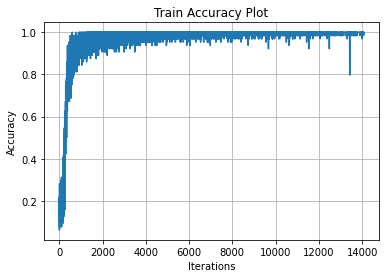

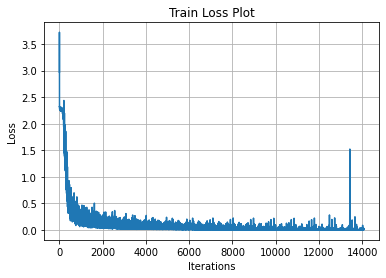

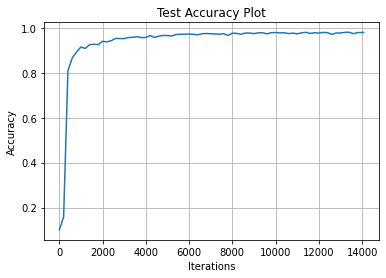

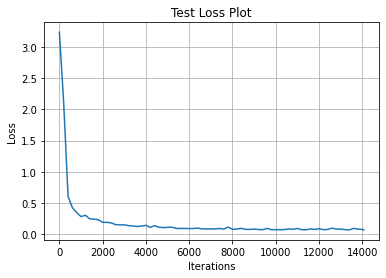

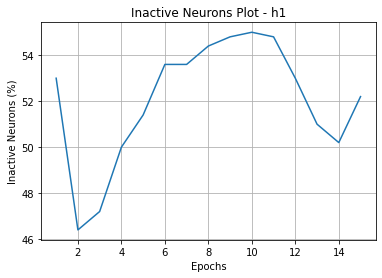

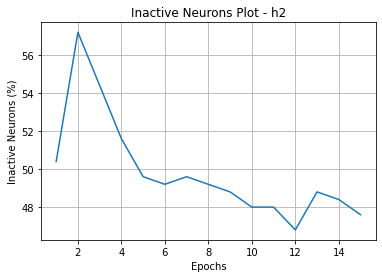

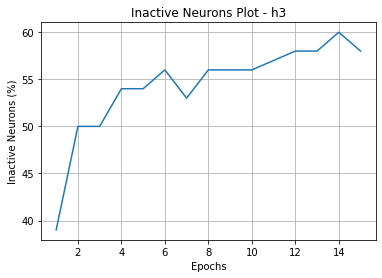

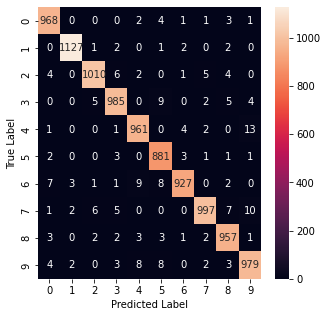

{'F1': 0.9792015186478944,
 'accuracy': 97.92,
 'conf_mat': array([[ 968,    0,    0,    0,    2,    4,    1,    1,    3,    1],
       [   0, 1127,    1,    2,    0,    1,    2,    0,    2,    0],
       [   4,    0, 1010,    6,    2,    0,    1,    5,    4,    0],
       [   0,    0,    5,  985,    0,    9,    0,    2,    5,    4],
       [   1,    0,    0,    1,  961,    0,    4,    2,    0,   13],
       [   2,    0,    0,    3,    0,  881,    3,    1,    1,    1],
       [   7,    3,    1,    1,    9,    8,  927,    0,    2,    0],
       [   1,    2,    6,    5,    0,    0,    0,  997,    7,   10],
       [   3,    0,    2,    2,    3,    3,    1,    2,  957,    1],
       [   4,    2,    0,    3,    8,    8,    0,    2,    3,  979]]),
 'error_rate': 2.080000000000004,
 'precision': 0.9792729807198599,
 'recall': 0.9792}


Input Layer:  784 , Activation: linear
Hidden Layer  1 :  500 , Activation:  sigmoid
Hidden Layer  2 :  250 , Activation:  sigmoid
Hidden Layer  3 :  100 , Activation:  sigmoid
Output Layer:  10 , Activation: softmax

Training MLP with following configuration:
{'activation': 'sigmoid',
 'batch_size': 64,
 'hidden_layer_size': [500, 250, 100],
 'lr': 0.1,
 'num_epochs': 15,
 'num_hidden_layers': 3,
 'optimizer': 'sgd',
 'weight_decay': 0,
 'weights_initializer': 'xavier_w_only'}


Epoch 1 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 9 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 10 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 11 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 12 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 13 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 14 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 15 :


  0%|          | 0/938 [00:00<?, ?it/s]


Final training report:
{'accuracy': 0.9417666666666666,
 'error_rate': 5.823333333333336,
 'loss': 0.19377816088069424}

Final test report:
{'accuracy': 0.9386,
 'error_rate': 6.140000000000001,
 'loss': 0.2031788283412595,
 'pred_labels': array([8, 4, 8, ..., 3, 3, 8])}


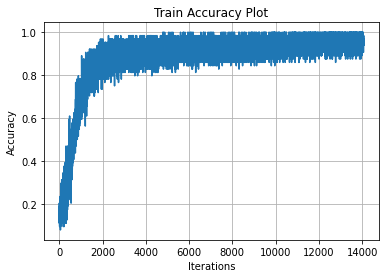

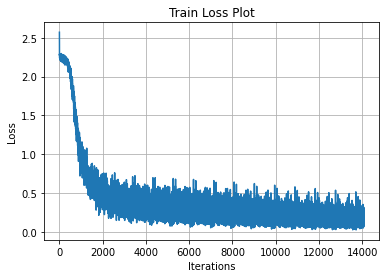

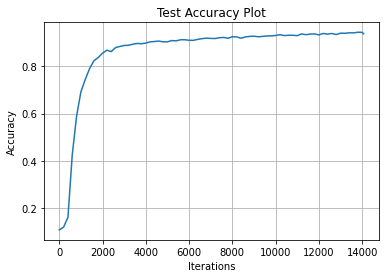

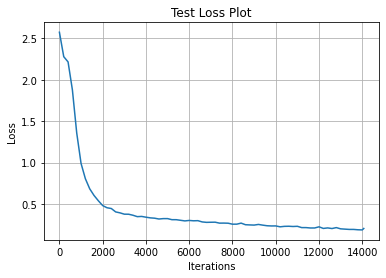

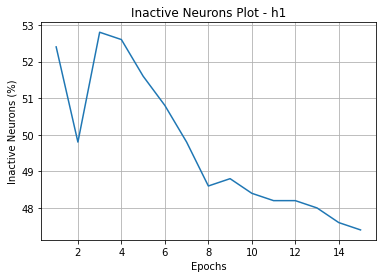

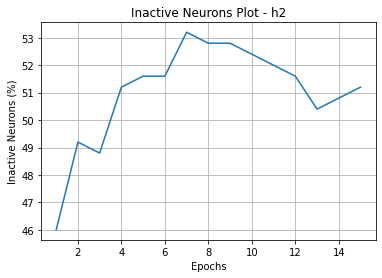

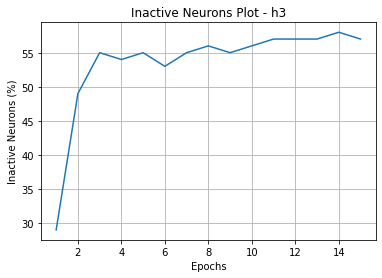

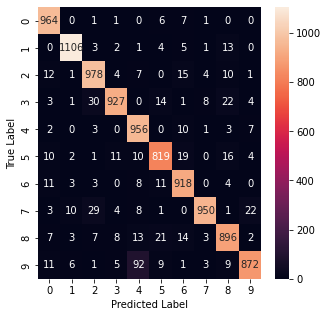

{'F1': 0.9385345530656668,
 'accuracy': 93.86,
 'conf_mat': array([[ 964,    0,    1,    1,    0,    6,    7,    1,    0,    0],
       [   0, 1106,    3,    2,    1,    4,    5,    1,   13,    0],
       [  12,    1,  978,    4,    7,    0,   15,    4,   10,    1],
       [   3,    1,   30,  927,    0,   14,    1,    8,   22,    4],
       [   2,    0,    3,    0,  956,    0,   10,    1,    3,    7],
       [  10,    2,    1,   11,   10,  819,   19,    0,   16,    4],
       [  11,    3,    3,    0,    8,   11,  918,    0,    4,    0],
       [   3,   10,   29,    4,    8,    1,    0,  950,    1,   22],
       [   7,    3,    7,    8,   13,   21,   14,    3,  896,    2],
       [  11,    6,    1,    5,   92,    9,    1,    3,    9,  872]]),
 'error_rate': 6.140000000000001,
 'precision': 0.9399099817191007,
 'recall': 0.9386}


Input Layer:  784 , Activation: linear
Hidden Layer  1 :  500 , Activation:  sigmoid
Hidden Layer  2 :  250 , Activation:  sigmoid
Hidden Layer  3 :  100 , Activation:  sigmoid
Output Layer:  10 , Activation: softmax

Training MLP with following configuration:
{'activation': 'sigmoid',
 'batch_size': 64,
 'hidden_layer_size': [500, 250, 100],
 'lr': 0.01,
 'num_epochs': 15,
 'num_hidden_layers': 3,
 'optimizer': 'sgd',
 'weight_decay': 0,
 'weights_initializer': 'xavier_w_only'}


Epoch 1 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 9 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 10 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 11 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 12 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 13 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 14 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 15 :


  0%|          | 0/938 [00:00<?, ?it/s]


Final training report:
{'accuracy': 0.79225, 'error_rate': 20.775, 'loss': 0.7035177007486386}

Final test report:
{'accuracy': 0.8005,
 'error_rate': 19.950000000000003,
 'loss': 0.6917799395069127,
 'pred_labels': array([8, 9, 8, ..., 3, 5, 8])}


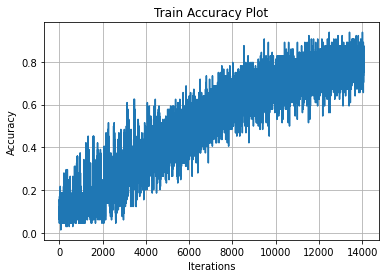

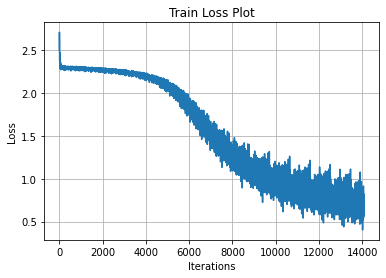

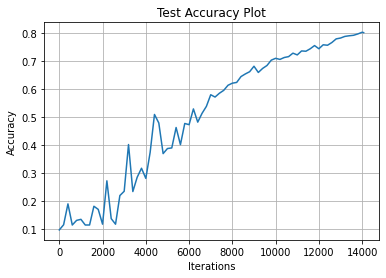

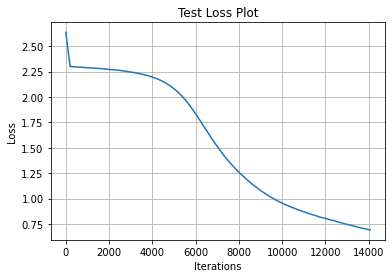

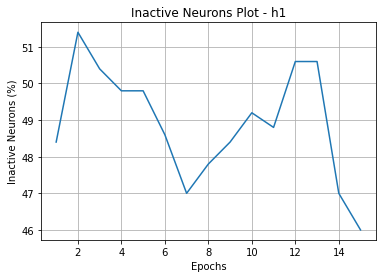

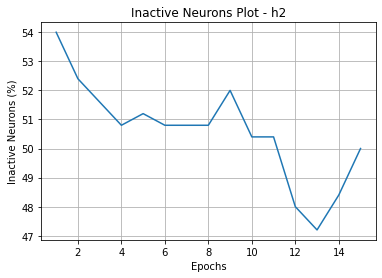

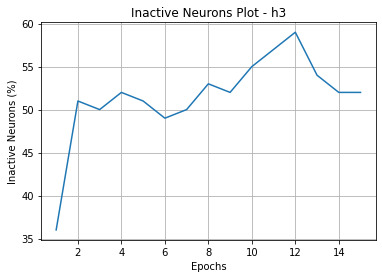

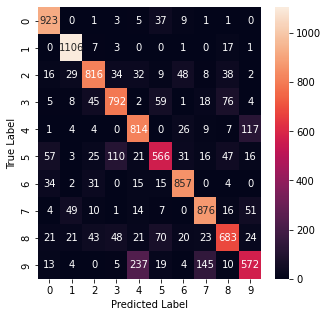

{'F1': 0.796802890714651,
 'accuracy': 80.05,
 'conf_mat': array([[ 923,    0,    1,    3,    5,   37,    9,    1,    1,    0],
       [   0, 1106,    7,    3,    0,    0,    1,    0,   17,    1],
       [  16,   29,  816,   34,   32,    9,   48,    8,   38,    2],
       [   5,    8,   45,  792,    2,   59,    1,   18,   76,    4],
       [   1,    4,    4,    0,  814,    0,   26,    9,    7,  117],
       [  57,    3,   25,  110,   21,  566,   31,   16,   47,   16],
       [  34,    2,   31,    0,   15,   15,  857,    0,    4,    0],
       [   4,   49,   10,    1,   14,    7,    0,  876,   16,   51],
       [  21,   21,   43,   48,   21,   70,   20,   23,  683,   24],
       [  13,    4,    0,    5,  237,   19,    4,  145,   10,  572]]),
 'error_rate': 19.950000000000003,
 'precision': 0.7979377370412171,
 'recall': 0.8005}


Input Layer:  784 , Activation: linear
Hidden Layer  1 :  500 , Activation:  sigmoid
Hidden Layer  2 :  250 , Activation:  sigmoid
Hidden Layer  3 :  100 , Activation:  sigmoid
Output Layer:  10 , Activation: softmax

Training MLP with following configuration:
{'activation': 'sigmoid',
 'batch_size': 64,
 'hidden_layer_size': [500, 250, 100],
 'lr': 0.001,
 'num_epochs': 15,
 'num_hidden_layers': 3,
 'optimizer': 'sgd',
 'weight_decay': 0,
 'weights_initializer': 'xavier_w_only'}


Epoch 1 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 9 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 10 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 11 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 12 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 13 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 14 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 15 :


  0%|          | 0/938 [00:00<?, ?it/s]


Final training report:
{'accuracy': 0.11238333333333334,
 'error_rate': 88.76166666666667,
 'loss': 2.283294569477284}

Final test report:
{'accuracy': 0.1135,
 'error_rate': 88.64999999999999,
 'loss': 2.2828879821311516,
 'pred_labels': array([1, 1, 1, ..., 1, 1, 1])}


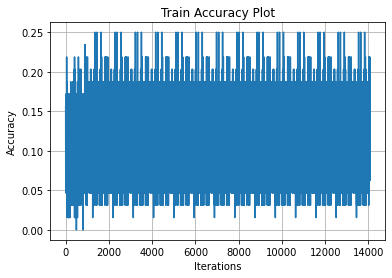

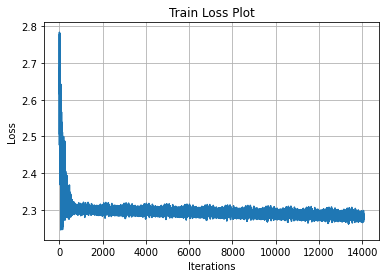

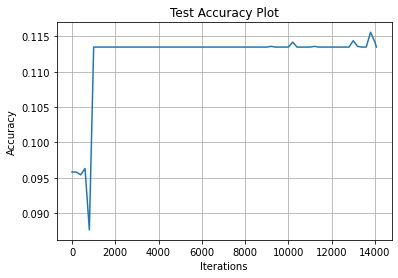

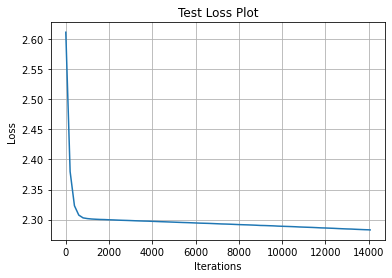

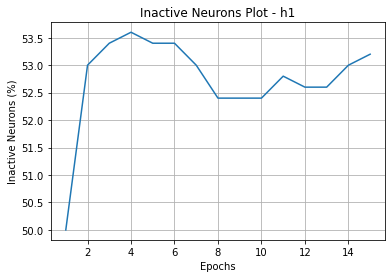

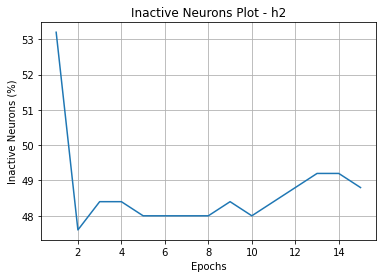

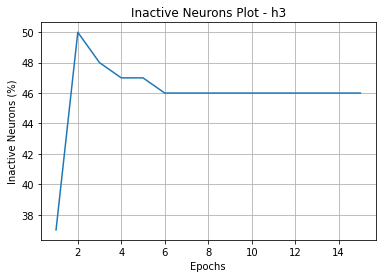

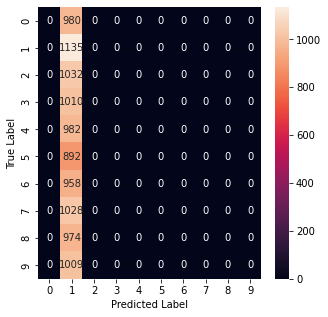

{'F1': 0.023138302649304,
 'accuracy': 11.35,
 'conf_mat': array([[   0,  980,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1135,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1032,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1010,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  982,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  892,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  958,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1028,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  974,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1009,    0,    0,    0,    0,    0,    0,    0,    0]]),
 'error_rate': 88.64999999999999,
 'precision': 0.01288225,
 'recall': 0.1135}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
for config in configs:
    direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/MLP_pics/'
    prefix = direc + 'sig_%s'%(config['lr'])
    network, report = train(config, data)
    # Plotting the relevant graphs
    plotGraphs(report, config, prefix)

    # Calculating relevant metrics
    mets = calculateMetrics(report, data, prefix)
    pprint.pprint(mets)

In [55]:
configs = [{
    'num_epochs' : 15,
    'num_hidden_layers' : 3,
    'hidden_layer_size' : [500, 250, 100],
    'weight_decay' : 0,
    'lr' : lr,
    'optimizer' : 'sgd',
    'batch_size' : 64,
    'weights_initializer' : 'xavier_w_only',
    'activation' : 'sigmoid',
} for lr in [1,1e-1,1e-2,1e-3]]

Input Layer:  784 , Activation: linear
Hidden Layer  1 :  500 , Activation:  sigmoid
Hidden Layer  2 :  250 , Activation:  sigmoid
Hidden Layer  3 :  100 , Activation:  sigmoid
Output Layer:  10 , Activation: softmax

Training MLP with following configuration:
{'activation': 'sigmoid',
 'batch_size': 64,
 'hidden_layer_size': [500, 250, 100],
 'lr': 1,
 'num_epochs': 15,
 'num_hidden_layers': 3,
 'optimizer': 'sgd',
 'weight_decay': 0,
 'weights_initializer': 'xavier_w_only'}


Epoch 1 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 9 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 10 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 11 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 12 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 13 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 14 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 15 :


  0%|          | 0/938 [00:00<?, ?it/s]


Final training report:
{'accuracy': 0.9945666666666667,
 'error_rate': 0.543333333333329,
 'loss': 0.01762486271998191}

Final test report:
{'accuracy': 0.9798,
 'error_rate': 2.0199999999999996,
 'loss': 0.07309513127326236,
 'pred_labels': array([8, 4, 8, ..., 3, 3, 8])}


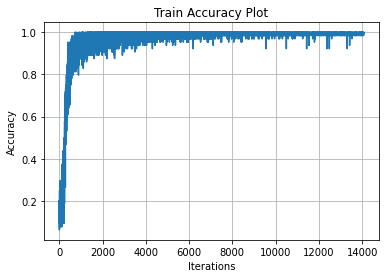

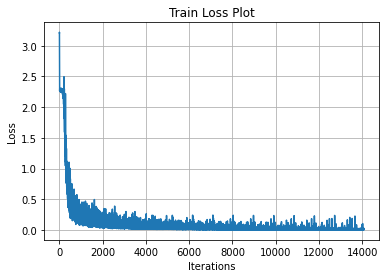

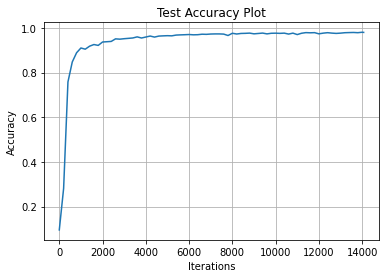

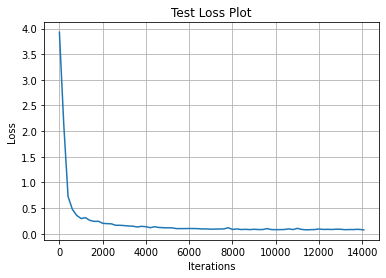

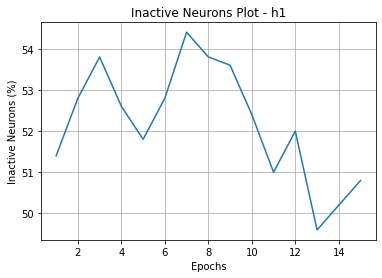

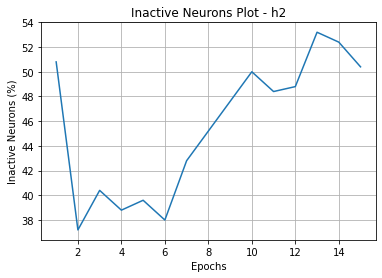

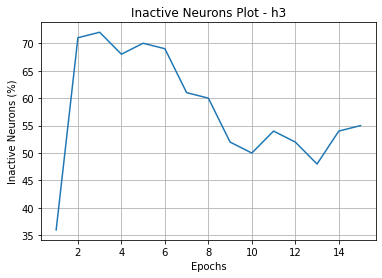

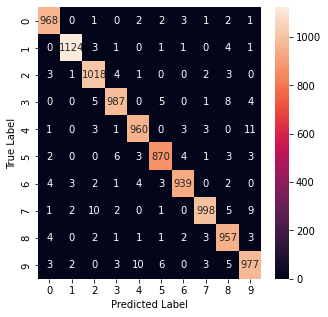

{'F1': 0.9798026065682308,
 'accuracy': 97.98,
 'conf_mat': array([[ 968,    0,    1,    0,    2,    2,    3,    1,    2,    1],
       [   0, 1124,    3,    1,    0,    1,    1,    0,    4,    1],
       [   3,    1, 1018,    4,    1,    0,    0,    2,    3,    0],
       [   0,    0,    5,  987,    0,    5,    0,    1,    8,    4],
       [   1,    0,    3,    1,  960,    0,    3,    3,    0,   11],
       [   2,    0,    0,    6,    3,  870,    4,    1,    3,    3],
       [   4,    3,    2,    1,    4,    3,  939,    0,    2,    0],
       [   1,    2,   10,    2,    0,    1,    0,  998,    5,    9],
       [   4,    0,    2,    1,    1,    1,    2,    3,  957,    3],
       [   3,    2,    0,    3,   10,    6,    0,    3,    5,  977]]),
 'error_rate': 2.0199999999999996,
 'precision': 0.9798408174276315,
 'recall': 0.9798}


Input Layer:  784 , Activation: linear
Hidden Layer  1 :  500 , Activation:  sigmoid
Hidden Layer  2 :  250 , Activation:  sigmoid
Hidden Layer  3 :  100 , Activation:  sigmoid
Output Layer:  10 , Activation: softmax

Training MLP with following configuration:
{'activation': 'sigmoid',
 'batch_size': 64,
 'hidden_layer_size': [500, 250, 100],
 'lr': 0.1,
 'num_epochs': 15,
 'num_hidden_layers': 3,
 'optimizer': 'sgd',
 'weight_decay': 0,
 'weights_initializer': 'xavier_w_only'}


Epoch 1 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 9 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 10 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 11 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 12 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 13 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 14 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 15 :


  0%|          | 0/938 [00:00<?, ?it/s]


Final training report:
{'accuracy': 0.94265,
 'error_rate': 5.735000000000001,
 'loss': 0.19067091017063428}

Final test report:
{'accuracy': 0.9387,
 'error_rate': 6.130000000000003,
 'loss': 0.1984608032689219,
 'pred_labels': array([8, 4, 8, ..., 3, 3, 8])}


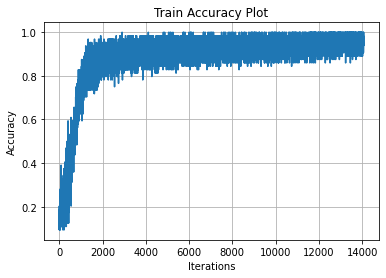

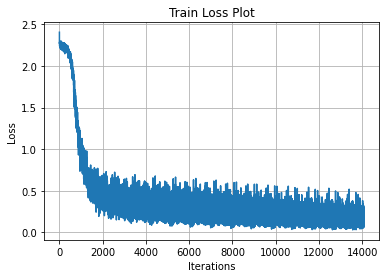

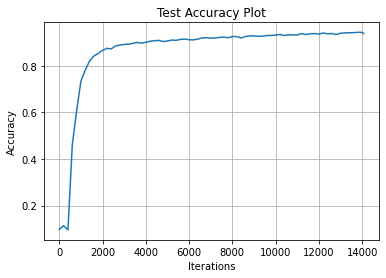

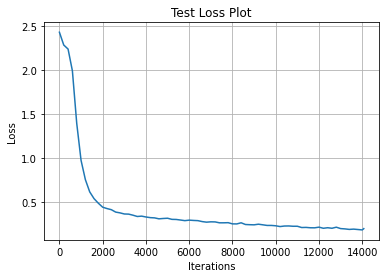

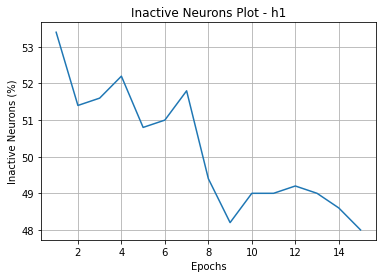

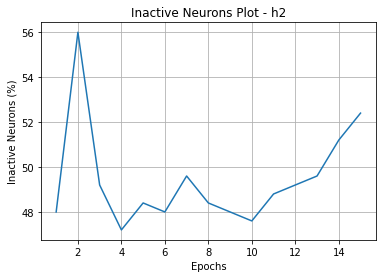

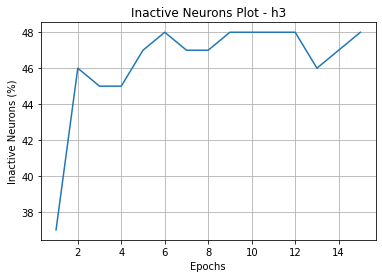

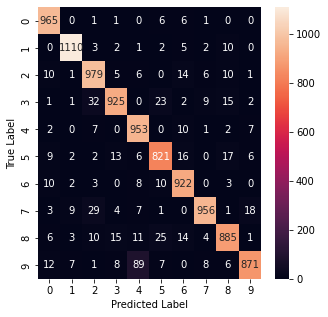

{'F1': 0.9385595277235763,
 'accuracy': 93.87,
 'conf_mat': array([[ 965,    0,    1,    1,    0,    6,    6,    1,    0,    0],
       [   0, 1110,    3,    2,    1,    2,    5,    2,   10,    0],
       [  10,    1,  979,    5,    6,    0,   14,    6,   10,    1],
       [   1,    1,   32,  925,    0,   23,    2,    9,   15,    2],
       [   2,    0,    7,    0,  953,    0,   10,    1,    2,    7],
       [   9,    2,    2,   13,    6,  821,   16,    0,   17,    6],
       [  10,    2,    3,    0,    8,   10,  922,    0,    3,    0],
       [   3,    9,   29,    4,    7,    1,    0,  956,    1,   18],
       [   6,    3,   10,   15,   11,   25,   14,    4,  885,    1],
       [  12,    7,    1,    8,   89,    7,    0,    8,    6,  871]]),
 'error_rate': 6.130000000000003,
 'precision': 0.9397157574722687,
 'recall': 0.9387}


Input Layer:  784 , Activation: linear
Hidden Layer  1 :  500 , Activation:  sigmoid
Hidden Layer  2 :  250 , Activation:  sigmoid
Hidden Layer  3 :  100 , Activation:  sigmoid
Output Layer:  10 , Activation: softmax

Training MLP with following configuration:
{'activation': 'sigmoid',
 'batch_size': 64,
 'hidden_layer_size': [500, 250, 100],
 'lr': 0.01,
 'num_epochs': 15,
 'num_hidden_layers': 3,
 'optimizer': 'sgd',
 'weight_decay': 0,
 'weights_initializer': 'xavier_w_only'}


Epoch 1 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 9 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 10 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 11 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 12 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 13 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 14 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 15 :


  0%|          | 0/938 [00:00<?, ?it/s]


Final training report:
{'accuracy': 0.8008333333333333,
 'error_rate': 19.91666666666667,
 'loss': 0.6777081027340852}

Final test report:
{'accuracy': 0.8048,
 'error_rate': 19.520000000000003,
 'loss': 0.6687722935630123,
 'pred_labels': array([8, 9, 8, ..., 8, 5, 8])}


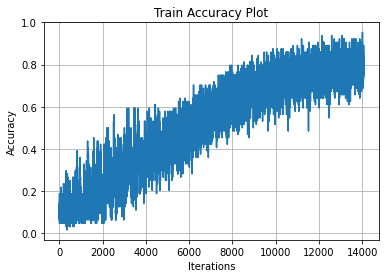

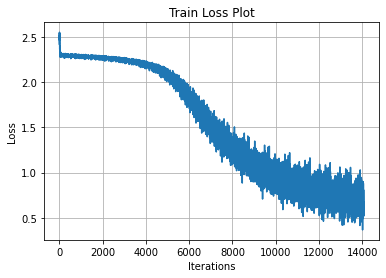

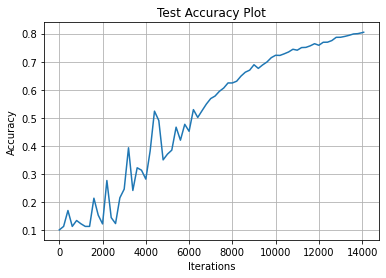

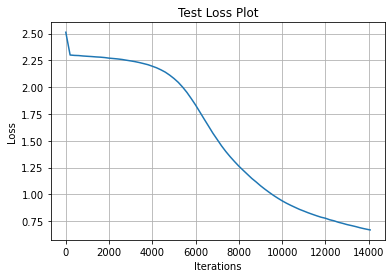

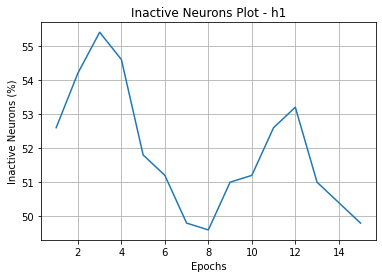

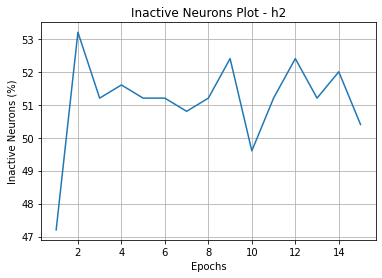

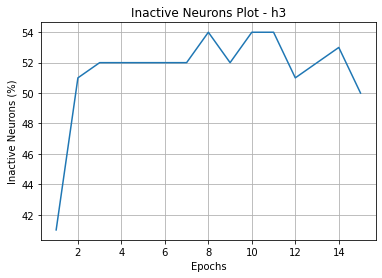

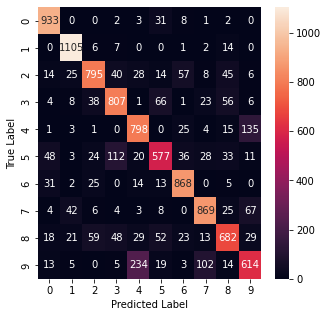

{'F1': 0.8018844379943754,
 'accuracy': 80.47999999999999,
 'conf_mat': array([[ 933,    0,    0,    2,    3,   31,    8,    1,    2,    0],
       [   0, 1105,    6,    7,    0,    0,    1,    2,   14,    0],
       [  14,   25,  795,   40,   28,   14,   57,    8,   45,    6],
       [   4,    8,   38,  807,    1,   66,    1,   23,   56,    6],
       [   1,    3,    1,    0,  798,    0,   25,    4,   15,  135],
       [  48,    3,   24,  112,   20,  577,   36,   28,   33,   11],
       [  31,    2,   25,    0,   14,   13,  868,    0,    5,    0],
       [   4,   42,    6,    4,    3,    8,    0,  869,   25,   67],
       [  18,   21,   59,   48,   29,   52,   23,   13,  682,   29],
       [  13,    5,    0,    5,  234,   19,    3,  102,   14,  614]]),
 'error_rate': 19.520000000000003,
 'precision': 0.8023054335766526,
 'recall': 0.8048}


Input Layer:  784 , Activation: linear
Hidden Layer  1 :  500 , Activation:  sigmoid
Hidden Layer  2 :  250 , Activation:  sigmoid
Hidden Layer  3 :  100 , Activation:  sigmoid
Output Layer:  10 , Activation: softmax

Training MLP with following configuration:
{'activation': 'sigmoid',
 'batch_size': 64,
 'hidden_layer_size': [500, 250, 100],
 'lr': 0.001,
 'num_epochs': 15,
 'num_hidden_layers': 3,
 'optimizer': 'sgd',
 'weight_decay': 0,
 'weights_initializer': 'xavier_w_only'}


Epoch 1 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 9 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 10 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 11 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 12 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 13 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 14 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 15 :


  0%|          | 0/938 [00:00<?, ?it/s]


Final training report:
{'accuracy': 0.11236666666666667,
 'error_rate': 88.76333333333332,
 'loss': 2.2845441100886035}

Final test report:
{'accuracy': 0.1135,
 'error_rate': 88.64999999999999,
 'loss': 2.2840094130560757,
 'pred_labels': array([1, 1, 1, ..., 1, 1, 1])}


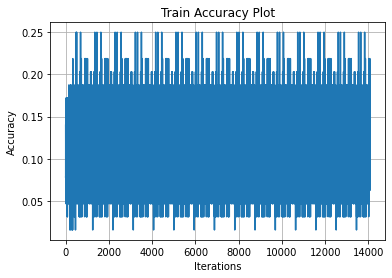

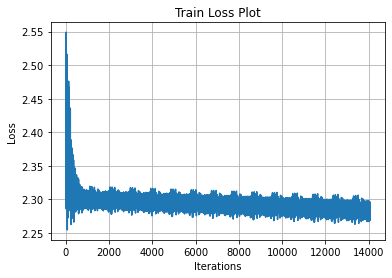

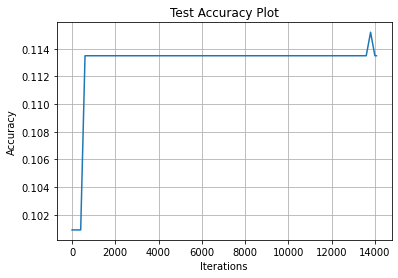

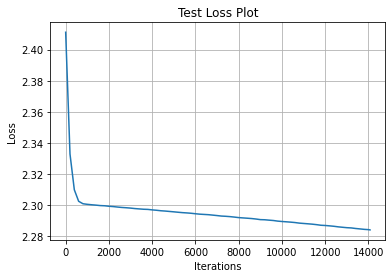

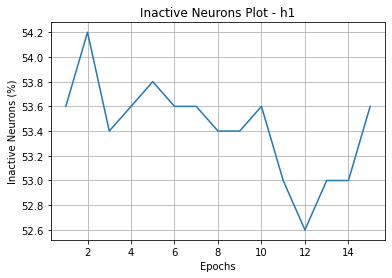

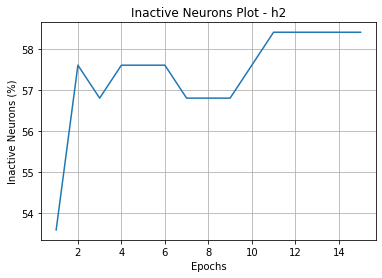

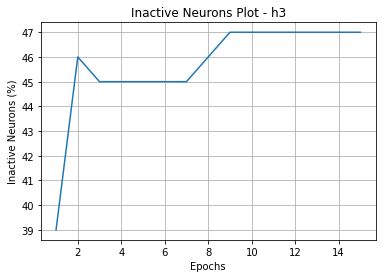

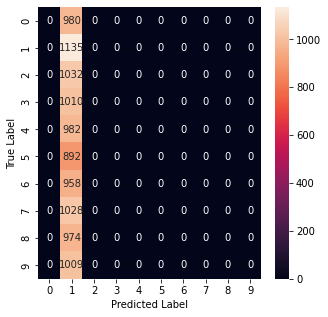

{'F1': 0.023138302649304,
 'accuracy': 11.35,
 'conf_mat': array([[   0,  980,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1135,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1032,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1010,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  982,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  892,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  958,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1028,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  974,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1009,    0,    0,    0,    0,    0,    0,    0,    0]]),
 'error_rate': 88.64999999999999,
 'precision': 0.01288225,
 'recall': 0.1135}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
for config in configs:
    direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/MLP_pics/'
    prefix = direc + 'sigmoid_%s'%(config['lr'])
    network, report = train(config, data)
    # Plotting the relevant graphs
    plotGraphs(report, config, prefix)

    # Calculating relevant metrics
    mets = calculateMetrics(report, data, prefix)
    pprint.pprint(mets)

## Relu MLP

In [26]:
config = {
    'num_epochs' : 15,
    'num_hidden_layers' : 3,
    'hidden_layer_size' : [500, 250, 100],
    'weight_decay' : 0,
    'lr' : 1e-1,
    'optimizer' : 'sgd',
    'batch_size' : 64,
    'weights_initializer' : 'xavier_w_only',
    'activation' : 'relu',
}

Input Layer:  784 , Activation: linear
Hidden Layer  1 :  500 , Activation:  relu
Hidden Layer  2 :  250 , Activation:  relu
Hidden Layer  3 :  100 , Activation:  relu
Output Layer:  10 , Activation: softmax

Training MLP with following configuration:
{'activation': 'relu',
 'batch_size': 64,
 'hidden_layer_size': [500, 250, 100],
 'lr': 0.1,
 'num_epochs': 15,
 'num_hidden_layers': 3,
 'optimizer': 'sgd',
 'weight_decay': 0,
 'weights_initializer': 'xavier_w_only'}


Epoch 1 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 9 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 10 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 11 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 12 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 13 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 14 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 15 :


  0%|          | 0/938 [00:00<?, ?it/s]


Final training report:
{'accuracy': 0.9999166666666667,
 'error_rate': 0.008333333333332416,
 'loss': 0.0011469708338502982}

Final test report:
{'accuracy': 0.9825,
 'error_rate': 1.749999999999996,
 'loss': 0.07572040497195158,
 'pred_labels': array([8, 4, 8, ..., 3, 3, 8])}


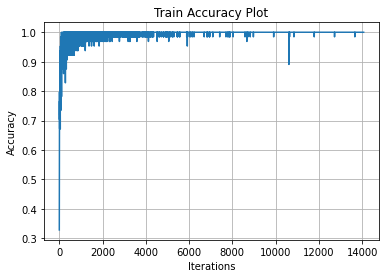

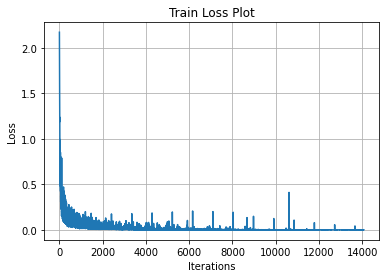

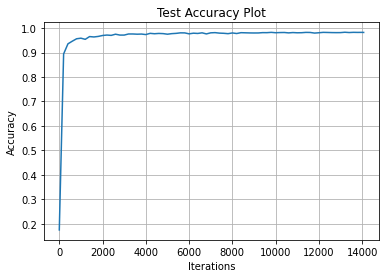

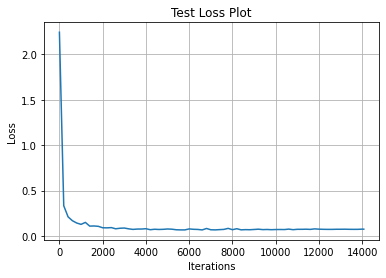

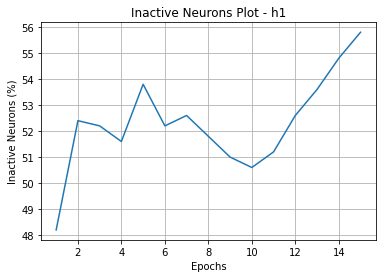

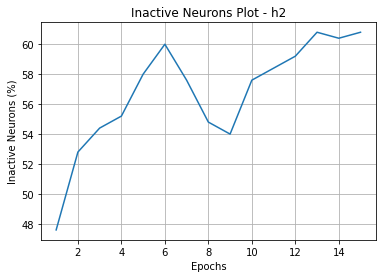

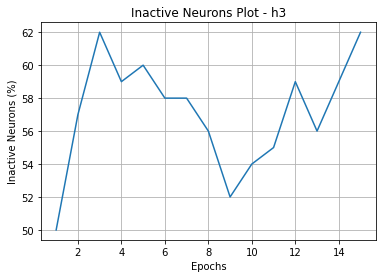

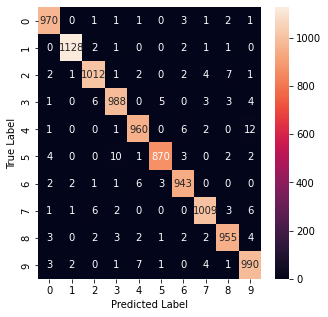

{'F1': 0.9825017478724744,
 'accuracy': 98.25,
 'conf_mat': array([[ 970,    0,    1,    1,    1,    0,    3,    1,    2,    1],
       [   0, 1128,    2,    1,    0,    0,    2,    1,    1,    0],
       [   2,    1, 1012,    1,    2,    0,    2,    4,    7,    1],
       [   1,    0,    6,  988,    0,    5,    0,    3,    3,    4],
       [   1,    0,    0,    1,  960,    0,    6,    2,    0,   12],
       [   4,    0,    0,   10,    1,  870,    3,    0,    2,    2],
       [   2,    2,    1,    1,    6,    3,  943,    0,    0,    0],
       [   1,    1,    6,    2,    0,    0,    0, 1009,    3,    6],
       [   3,    0,    2,    3,    2,    1,    2,    2,  955,    4],
       [   3,    2,    0,    1,    7,    1,    0,    4,    1,  990]]),
 'error_rate': 1.749999999999996,
 'precision': 0.9825211508393319,
 'recall': 0.9825}


In [27]:
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/MLP_pics/'
prefix = direc + 'relu'
network, report = train(config, data)
# Plotting the relevant graphs of losses and accuracies
plotGraphs(report, config, prefix)

# Calculating relevant metrics
mets = calculateMetrics(report, data, prefix)
pprint.pprint(mets)

## Tanh MLP

In [28]:
config = {
    'num_epochs' : 15,
    'num_hidden_layers' : 3,
    'hidden_layer_size' : [500, 250, 100],
    'weight_decay' : 0,
    'lr' : 1e-1,
    'optimizer' : 'sgd',
    'batch_size' : 64,
    'weights_initializer' : 'xavier_w_only',
    'activation' : 'tanh',
}

Input Layer:  784 , Activation: linear
Hidden Layer  1 :  500 , Activation:  tanh
Hidden Layer  2 :  250 , Activation:  tanh
Hidden Layer  3 :  100 , Activation:  tanh
Output Layer:  10 , Activation: softmax

Training MLP with following configuration:
{'activation': 'tanh',
 'batch_size': 64,
 'hidden_layer_size': [500, 250, 100],
 'lr': 0.1,
 'num_epochs': 15,
 'num_hidden_layers': 3,
 'optimizer': 'sgd',
 'weight_decay': 0,
 'weights_initializer': 'xavier_w_only'}


Epoch 1 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 9 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 10 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 11 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 12 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 13 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 14 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 15 :


  0%|          | 0/938 [00:00<?, ?it/s]


Final training report:
{'accuracy': 0.9983,
 'error_rate': 0.17000000000000348,
 'loss': 0.009753541184497986}

Final test report:
{'accuracy': 0.9801,
 'error_rate': 1.9900000000000029,
 'loss': 0.062355297947265194,
 'pred_labels': array([8, 4, 8, ..., 3, 3, 8])}


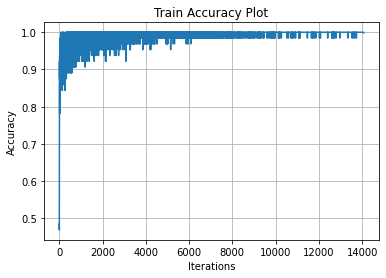

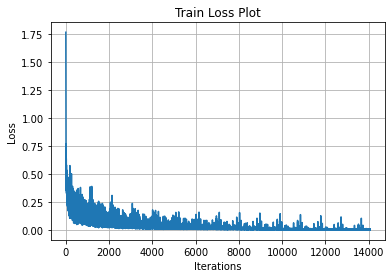

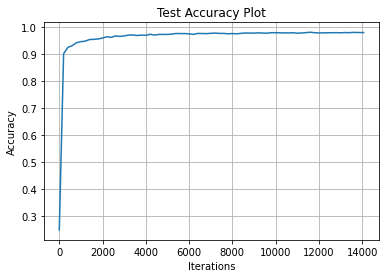

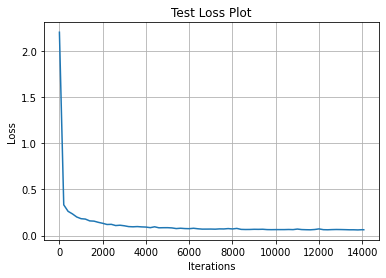

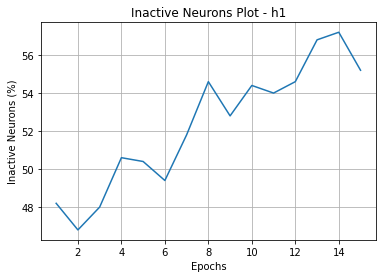

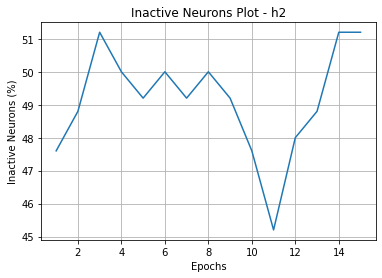

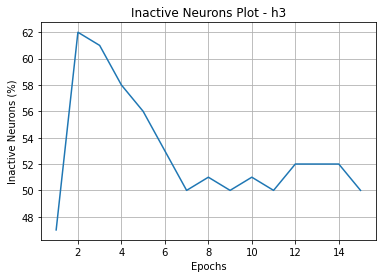

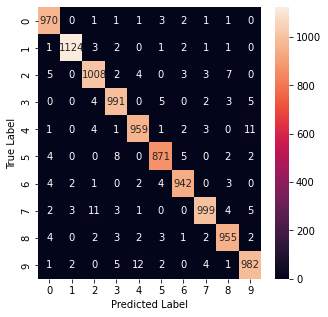

{'F1': 0.9800991384531224,
 'accuracy': 98.00999999999999,
 'conf_mat': array([[ 970,    0,    1,    1,    1,    3,    2,    1,    1,    0],
       [   1, 1124,    3,    2,    0,    1,    2,    1,    1,    0],
       [   5,    0, 1008,    2,    4,    0,    3,    3,    7,    0],
       [   0,    0,    4,  991,    0,    5,    0,    2,    3,    5],
       [   1,    0,    4,    1,  959,    1,    2,    3,    0,   11],
       [   4,    0,    0,    8,    0,  871,    5,    0,    2,    2],
       [   4,    2,    1,    0,    2,    4,  942,    0,    3,    0],
       [   2,    3,   11,    3,    1,    0,    0,  999,    4,    5],
       [   4,    0,    2,    3,    2,    3,    1,    2,  955,    2],
       [   1,    2,    0,    5,   12,    2,    0,    4,    1,  982]]),
 'error_rate': 1.9900000000000029,
 'precision': 0.9801171478598942,
 'recall': 0.9801}


In [29]:
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/MLP_pics/'
prefix = direc + 'tanh'
network, report = train(config, data)
# Plotting the relevant graphs of losses and accuracies
plotGraphs(report, config, prefix)

# Calculating relevant metrics
mets = calculateMetrics(report, data, prefix)
pprint.pprint(mets)

# Data Augmentation

In [17]:
def addGaussianNoise(input, mu=0, sigma=0.5):
    '''
    Adding Gaussian Noise to data
    Arguments:
    input       Training data that we are going to add noise to
    mu          mean of Gaussian noise we add
    sigma       Standard deviation of Gaussian noise we add

    Return:
    noisy_data  input with gaussian noise added to it
    ''' 
    gaussian_noise = np.random.normal(mu, sigma, input.shape)
    noisy_data = np.add(input, gaussian_noise)

    return noisy_data

In [19]:
noisy_train = addGaussianNoise(data['train']['X'])
# Ensuring that the maximum value in the data is 1
maxm = np.max(noisy_train)
noisy_train = noisy_train / maxm

noisy_data = {
    'train':{
        'X':noisy_train,
        'Y':data['train']['Y']
    },
    'test':{
        'X':data['test']['X'],
        'Y':data['test']['Y']
    }
}

In [20]:
config = {
    'num_epochs' : 15,
    'num_hidden_layers' : 3,
    'hidden_layer_size' : [500, 250, 100],
    'weight_decay' : 0,
    'lr' : 1e-1,
    'optimizer' : 'sgd',
    'batch_size' : 64,
    'weights_initializer' : 'xavier_w_only',
    'activation' : 'sigmoid'
}

wandb: Currently logged in as: ani_r (use `wandb login --relogin` to force relogin)


Input Layer:  784 , Activation: linear
Hidden Layer  1 :  500 , Activation:  sigmoid
Hidden Layer  2 :  250 , Activation:  sigmoid
Hidden Layer  3 :  100 , Activation:  sigmoid
Output Layer:  10 , Activation: softmax

Training MLP with following configuration:
{'activation': 'sigmoid',
 'batch_size': 64,
 'hidden_layer_size': [500, 250, 100],
 'lr': 0.1,
 'num_epochs': 15,
 'num_hidden_layers': 3,
 'optimizer': 'sgd',
 'weight_decay': 0,
 'weights_initializer': 'xavier_w_only'}


Epoch 1 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 9 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 10 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 11 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 12 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 13 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 14 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 15 :


  0%|          | 0/938 [00:00<?, ?it/s]


Final training report:
{'accuracy': 0.827,
 'error_rate': 17.300000000000004,
 'loss': 0.5229517375101637}

Final test report:
{'accuracy': 0.8832,
 'error_rate': 11.680000000000001,
 'loss': 0.4393656464613521,
 'pred_labels': array([8, 4, 8, ..., 3, 3, 8])}


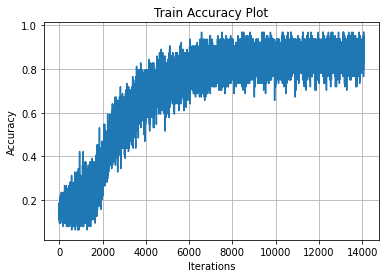

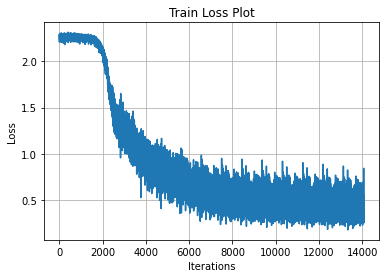

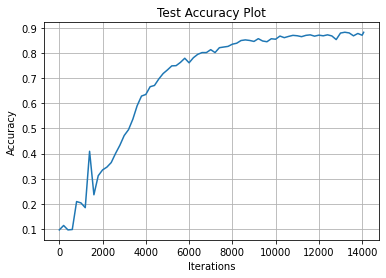

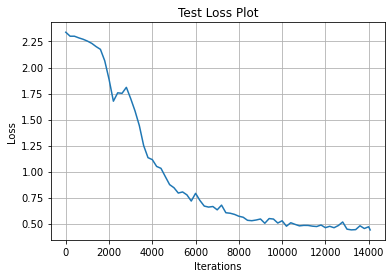

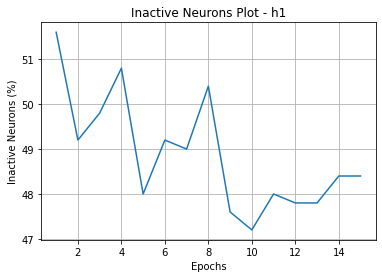

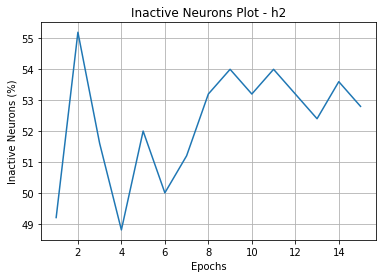

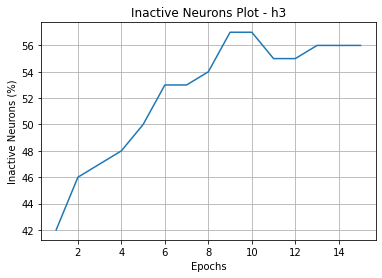

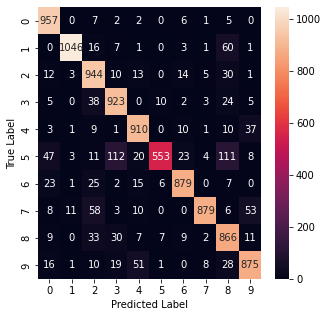

{'F1': 0.8820261145930617,
 'accuracy': 88.32,
 'conf_mat': array([[ 957,    0,    7,    2,    2,    0,    6,    1,    5,    0],
       [   0, 1046,   16,    7,    1,    0,    3,    1,   60,    1],
       [  12,    3,  944,   10,   13,    0,   14,    5,   30,    1],
       [   5,    0,   38,  923,    0,   10,    2,    3,   24,    5],
       [   3,    1,    9,    1,  910,    0,   10,    1,   10,   37],
       [  47,    3,   11,  112,   20,  553,   23,    4,  111,    8],
       [  23,    1,   25,    2,   15,    6,  879,    0,    7,    0],
       [   8,   11,   58,    3,   10,    0,    0,  879,    6,   53],
       [   9,    0,   33,   30,    7,    7,    9,    2,  866,   11],
       [  16,    1,   10,   19,   51,    1,    0,    8,   28,  875]]),
 'error_rate': 11.680000000000001,
 'precision': 0.8908429665963459,
 'recall': 0.8832}


In [21]:
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/MLP_pics/'
prefix = direc + 'augm'
network, report = train(config, noisy_data)
# Plotting the relevant graphs of losses and accuracies
plotGraphs(report, config, prefix)

# Calculating relevant metrics
mets = calculateMetrics(report, noisy_data, prefix)
pprint.pprint(mets)

In [18]:
noisy_train = addGaussianNoise(data['train']['X'], 0, 0.1)
# Ensuring that the maximum value in the data is 1
maxm = np.max(noisy_train)
noisy_train = noisy_train / maxm

noisy_data = {
    'train':{
        'X':noisy_train,
        'Y':data['train']['Y']
    },
    'test':{
        'X':data['test']['X'],
        'Y':data['test']['Y']
    }
}

In [19]:
config = {
    'num_epochs' : 15,
    'num_hidden_layers' : 3,
    'hidden_layer_size' : [500, 250, 100],
    'weight_decay' : 0,
    'lr' : 1e-1,
    'optimizer' : 'sgd',
    'batch_size' : 64,
    'weights_initializer' : 'xavier_w_only',
    'activation' : 'sigmoid'
}

wandb: Currently logged in as: ani_r (use `wandb login --relogin` to force relogin)


Input Layer:  784 , Activation: linear
Hidden Layer  1 :  500 , Activation:  sigmoid
Hidden Layer  2 :  250 , Activation:  sigmoid
Hidden Layer  3 :  100 , Activation:  sigmoid
Output Layer:  10 , Activation: softmax

Training MLP with following configuration:
{'activation': 'sigmoid',
 'batch_size': 64,
 'hidden_layer_size': [500, 250, 100],
 'lr': 0.1,
 'num_epochs': 15,
 'num_hidden_layers': 3,
 'optimizer': 'sgd',
 'weight_decay': 0,
 'weights_initializer': 'xavier_w_only'}


Epoch 1 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 9 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 10 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 11 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 12 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 13 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 14 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 15 :


  0%|          | 0/938 [00:00<?, ?it/s]


Final training report:
{'accuracy': 0.9234166666666667,
 'error_rate': 7.658333333333333,
 'loss': 0.2584005787896517}

Final test report:
{'accuracy': 0.926,
 'error_rate': 7.399999999999995,
 'loss': 0.2526643951964959,
 'pred_labels': array([8, 4, 8, ..., 3, 3, 8])}


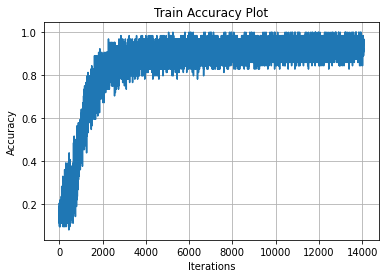

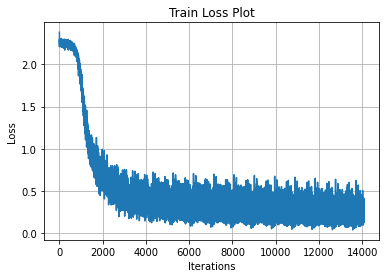

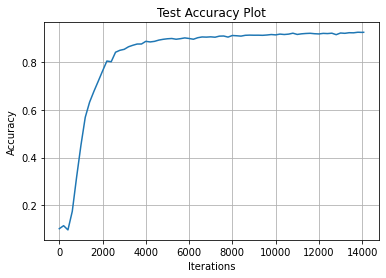

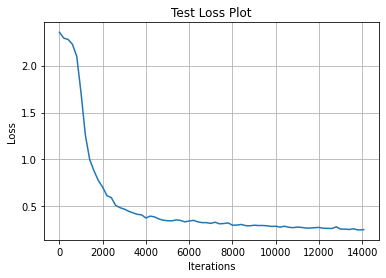

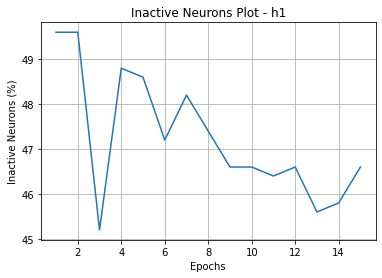

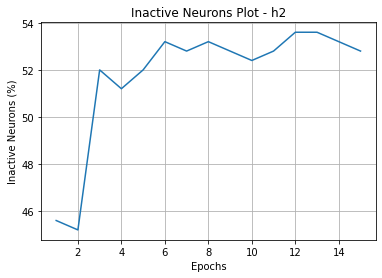

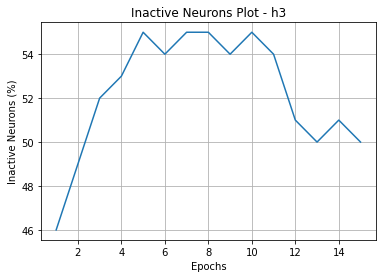

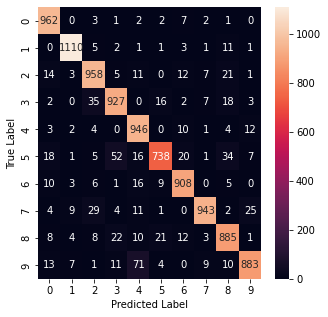

{'F1': 0.9257252595647824,
 'accuracy': 92.60000000000001,
 'conf_mat': array([[ 962,    0,    3,    1,    2,    2,    7,    2,    1,    0],
       [   0, 1110,    5,    2,    1,    1,    3,    1,   11,    1],
       [  14,    3,  958,    5,   11,    0,   12,    7,   21,    1],
       [   2,    0,   35,  927,    0,   16,    2,    7,   18,    3],
       [   3,    2,    4,    0,  946,    0,   10,    1,    4,   12],
       [  18,    1,    5,   52,   16,  738,   20,    1,   34,    7],
       [  10,    3,    6,    1,   16,    9,  908,    0,    5,    0],
       [   4,    9,   29,    4,   11,    1,    0,  943,    2,   25],
       [   8,    4,    8,   22,   10,   21,   12,    3,  885,    1],
       [  13,    7,    1,   11,   71,    4,    0,    9,   10,  883]]),
 'error_rate': 7.399999999999995,
 'precision': 0.9270577983098645,
 'recall': 0.926}


In [20]:
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/MLP_pics/'
prefix = direc + 'augm-2'
network, report = train(config, noisy_data)
# Plotting the relevant graphs of losses and accuracies
plotGraphs(report, config, prefix)

# Calculating relevant metrics
mets = calculateMetrics(report, noisy_data, prefix)
pprint.pprint(mets)

In [34]:
noisy_train = addGaussianNoise(data['train']['X'], 0, 0.03)
# Ensuring that the maximum value in the data is 1
maxm = np.max(noisy_train)
noisy_train = noisy_train / maxm

noisy_data = {
    'train':{
        'X':noisy_train,
        'Y':data['train']['Y']
    },
    'test':{
        'X':data['test']['X'],
        'Y':data['test']['Y']
    }
}

In [35]:
config = {
    'num_epochs' : 15,
    'num_hidden_layers' : 3,
    'hidden_layer_size' : [500, 250, 100],
    'weight_decay' : 0,
    'lr' : 1e-1,
    'optimizer' : 'sgd',
    'batch_size' : 64,
    'weights_initializer' : 'xavier_w_only',
    'activation' : 'sigmoid'
}

Input Layer:  784 , Activation: linear
Hidden Layer  1 :  500 , Activation:  sigmoid
Hidden Layer  2 :  250 , Activation:  sigmoid
Hidden Layer  3 :  100 , Activation:  sigmoid
Output Layer:  10 , Activation: softmax

Training MLP with following configuration:
{'activation': 'sigmoid',
 'batch_size': 64,
 'hidden_layer_size': [500, 250, 100],
 'lr': 0.1,
 'num_epochs': 15,
 'num_hidden_layers': 3,
 'optimizer': 'sgd',
 'weight_decay': 0,
 'weights_initializer': 'xavier_w_only'}


Epoch 1 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 9 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 10 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 11 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 12 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 13 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 14 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 15 :


  0%|          | 0/938 [00:00<?, ?it/s]


Final training report:
{'accuracy': 0.9354333333333333,
 'error_rate': 6.456666666666666,
 'loss': 0.21485748528150383}

Final test report:
{'accuracy': 0.9349,
 'error_rate': 6.510000000000005,
 'loss': 0.2141198921328431,
 'pred_labels': array([8, 4, 8, ..., 3, 3, 8])}


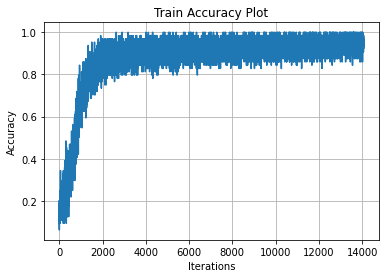

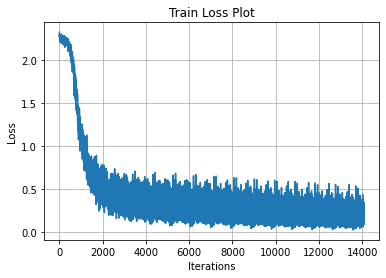

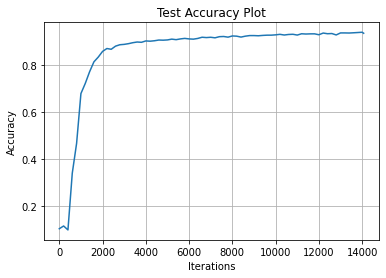

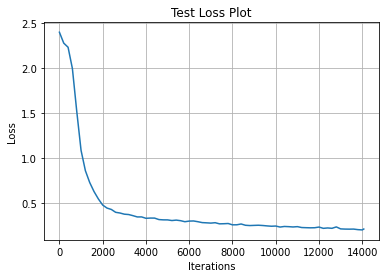

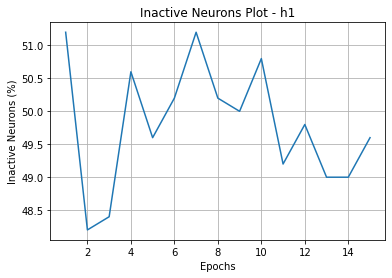

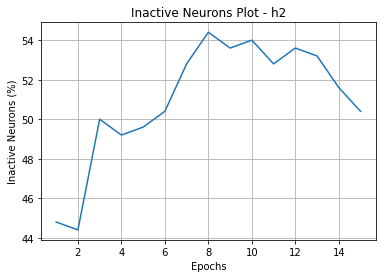

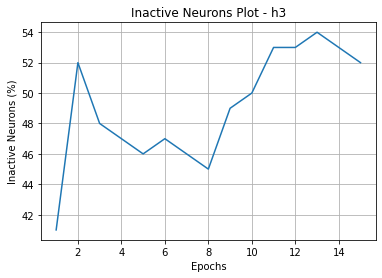

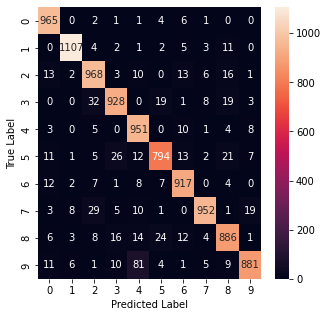

{'F1': 0.9348123146989059,
 'accuracy': 93.49,
 'conf_mat': array([[ 965,    0,    2,    1,    1,    4,    6,    1,    0,    0],
       [   0, 1107,    4,    2,    1,    2,    5,    3,   11,    0],
       [  13,    2,  968,    3,   10,    0,   13,    6,   16,    1],
       [   0,    0,   32,  928,    0,   19,    1,    8,   19,    3],
       [   3,    0,    5,    0,  951,    0,   10,    1,    4,    8],
       [  11,    1,    5,   26,   12,  794,   13,    2,   21,    7],
       [  12,    2,    7,    1,    8,    7,  917,    0,    4,    0],
       [   3,    8,   29,    5,   10,    1,    0,  952,    1,   19],
       [   6,    3,    8,   16,   14,   24,   12,    4,  886,    1],
       [  11,    6,    1,   10,   81,    4,    1,    5,    9,  881]]),
 'error_rate': 6.510000000000005,
 'precision': 0.9359313256754683,
 'recall': 0.9349}


In [36]:
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/MLP_pics/'
prefix = direc + 'augm-3'
network, report = train(config, noisy_data)
# Plotting the relevant graphs of losses and accuracies
plotGraphs(report, config, prefix)

# Calculating relevant metrics
mets = calculateMetrics(report, noisy_data, prefix)
pprint.pprint(mets)

# Regularization

In [34]:
config = {
    'num_epochs' : 15,
    'num_hidden_layers' : 3,
    'hidden_layer_size' : [500, 250, 100],
    'weight_decay' : 1e-1,
    'lr' : 1e-1,
    'optimizer' : 'sgd',
    'batch_size' : 64,
    'weights_initializer' : 'xavier_w_only',
    'activation' : 'sigmoid'
}

Input Layer:  784 , Activation: linear
Hidden Layer  1 :  500 , Activation:  sigmoid
Hidden Layer  2 :  250 , Activation:  sigmoid
Hidden Layer  3 :  100 , Activation:  sigmoid
Output Layer:  10 , Activation: softmax

Training MLP with following configuration:
{'activation': 'sigmoid',
 'batch_size': 64,
 'hidden_layer_size': [500, 250, 100],
 'lr': 0.1,
 'num_epochs': 15,
 'num_hidden_layers': 3,
 'optimizer': 'sgd',
 'weight_decay': 0.1,
 'weights_initializer': 'xavier_w_only'}


Epoch 1 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 9 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 10 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 11 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 12 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 13 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 14 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 15 :


  0%|          | 0/938 [00:00<?, ?it/s]


Final training report:
{'accuracy': 0.11236666666666667,
 'error_rate': 88.76333333333332,
 'loss': 2.314390349176021}

Final test report:
{'accuracy': 0.1135,
 'error_rate': 88.64999999999999,
 'loss': 2.314158964047054,
 'pred_labels': array([1, 1, 1, ..., 1, 1, 1])}


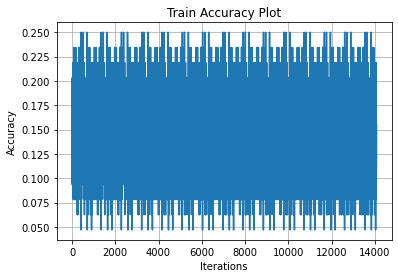

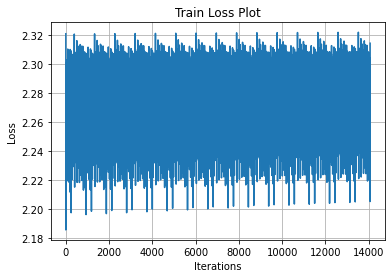

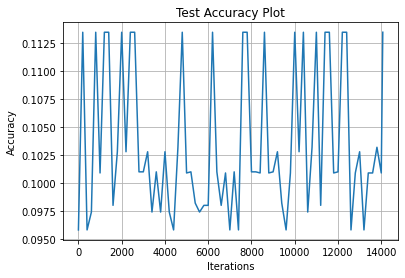

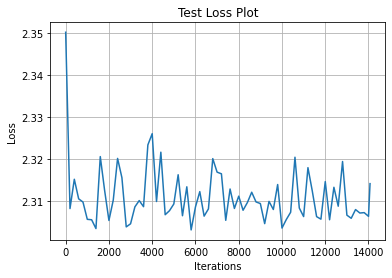

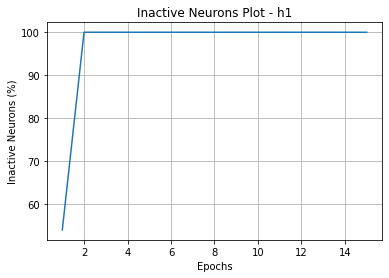

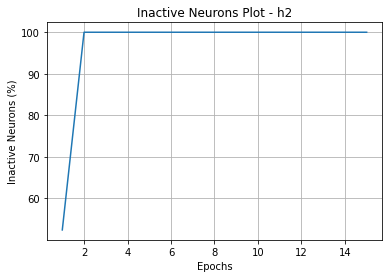

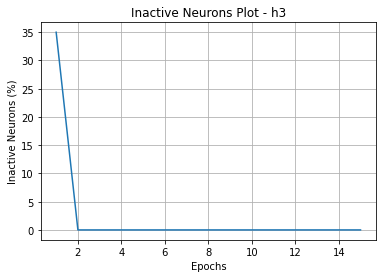

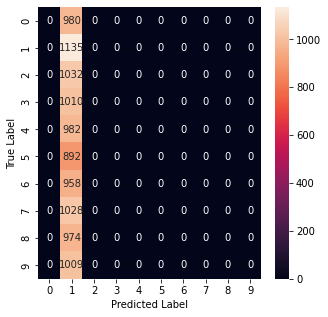

{'F1': 0.023138302649304,
 'accuracy': 11.35,
 'conf_mat': array([[   0,  980,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1135,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1032,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1010,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  982,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  892,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  958,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1028,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  974,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1009,    0,    0,    0,    0,    0,    0,    0,    0]]),
 'error_rate': 88.64999999999999,
 'precision': 0.01288225,
 'recall': 0.1135}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/MLP_pics/'
prefix = direc + 'regul'
network, report = train(config, data)
# Plotting the relevant graphs of losses and accuracies
plotGraphs(report, config, prefix)

# Calculating relevant metrics
mets = calculateMetrics(report, data, prefix)
pprint.pprint(mets)

In [21]:
config = {
    'num_epochs' : 15,
    'num_hidden_layers' : 3,
    'hidden_layer_size' : [500, 250, 100],
    'weight_decay' : 1e-2,
    'lr' : 1e-1,
    'optimizer' : 'sgd',
    'batch_size' : 64,
    'weights_initializer' : 'xavier_w_only',
    'activation' : 'sigmoid'
}

Input Layer:  784 , Activation: linear
Hidden Layer  1 :  500 , Activation:  sigmoid
Hidden Layer  2 :  250 , Activation:  sigmoid
Hidden Layer  3 :  100 , Activation:  sigmoid
Output Layer:  10 , Activation: softmax

Training MLP with following configuration:
{'activation': 'sigmoid',
 'batch_size': 64,
 'hidden_layer_size': [500, 250, 100],
 'lr': 0.1,
 'num_epochs': 15,
 'num_hidden_layers': 3,
 'optimizer': 'sgd',
 'weight_decay': 0.01,
 'weights_initializer': 'xavier_w_only'}


Epoch 1 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 9 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 10 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 11 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 12 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 13 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 14 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 15 :


  0%|          | 0/938 [00:00<?, ?it/s]


Final training report:
{'accuracy': 0.11236666666666667,
 'error_rate': 88.76333333333332,
 'loss': 2.308177934232182}

Final test report:
{'accuracy': 0.1135,
 'error_rate': 88.64999999999999,
 'loss': 2.3080717379625733,
 'pred_labels': array([1, 1, 1, ..., 1, 1, 1])}


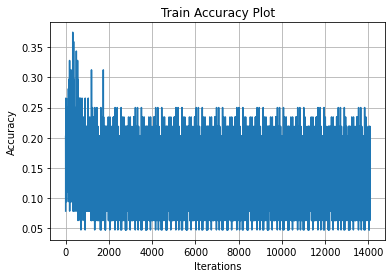

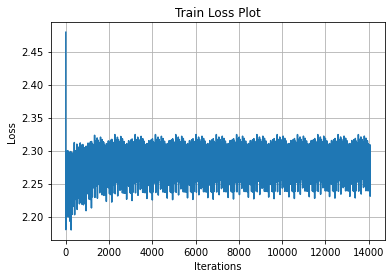

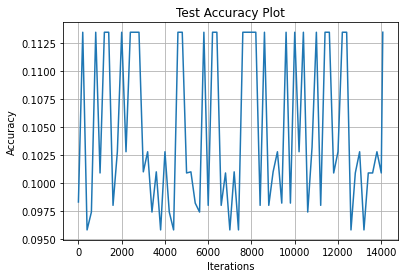

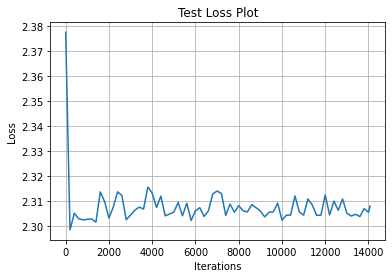

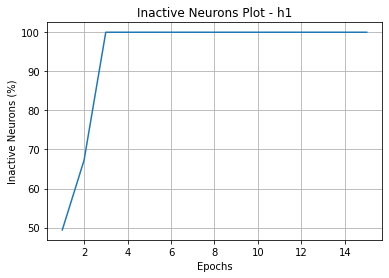

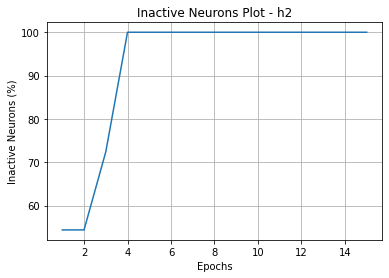

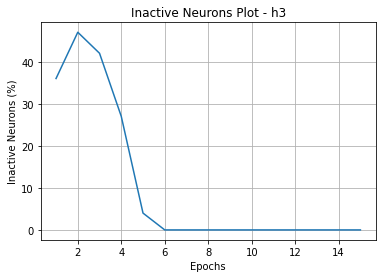

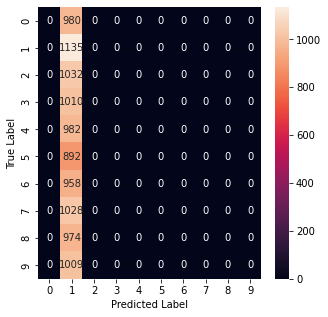

{'F1': 0.023138302649304,
 'accuracy': 11.35,
 'conf_mat': array([[   0,  980,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1135,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1032,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1010,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  982,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  892,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  958,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1028,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  974,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1009,    0,    0,    0,    0,    0,    0,    0,    0]]),
 'error_rate': 88.64999999999999,
 'precision': 0.01288225,
 'recall': 0.1135}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/MLP_pics/'
prefix = direc + 'regul-2'
network, report = train(config, data)
# Plotting the relevant graphs of losses and accuracies
plotGraphs(report, config, prefix)

# Calculating relevant metrics
mets = calculateMetrics(report, data, prefix)
pprint.pprint(mets)

In [32]:
config = {
    'num_epochs' : 15,
    'num_hidden_layers' : 3,
    'hidden_layer_size' : [500, 250, 100],
    'weight_decay' : 1e-3,
    'lr' : 1e-1,
    'optimizer' : 'sgd',
    'batch_size' : 64,
    'weights_initializer' : 'xavier_w_only',
    'activation' : 'sigmoid'
}

Input Layer:  784 , Activation: linear
Hidden Layer  1 :  500 , Activation:  sigmoid
Hidden Layer  2 :  250 , Activation:  sigmoid
Hidden Layer  3 :  100 , Activation:  sigmoid
Output Layer:  10 , Activation: softmax

Training MLP with following configuration:
{'activation': 'sigmoid',
 'batch_size': 64,
 'hidden_layer_size': [500, 250, 100],
 'lr': 0.1,
 'num_epochs': 15,
 'num_hidden_layers': 3,
 'optimizer': 'sgd',
 'weight_decay': 0.001,
 'weights_initializer': 'xavier_w_only'}


Epoch 1 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 9 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 10 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 11 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 12 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 13 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 14 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 15 :


  0%|          | 0/938 [00:00<?, ?it/s]


Final training report:
{'accuracy': 0.9004,
 'error_rate': 9.960000000000003,
 'loss': 0.3366116302046381}

Final test report:
{'accuracy': 0.8965,
 'error_rate': 10.350000000000003,
 'loss': 0.3372612506851182,
 'pred_labels': array([8, 4, 8, ..., 3, 5, 8])}


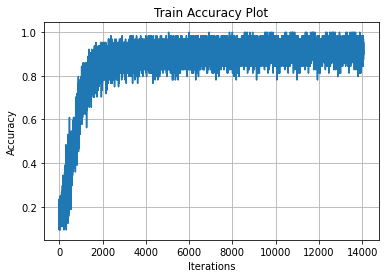

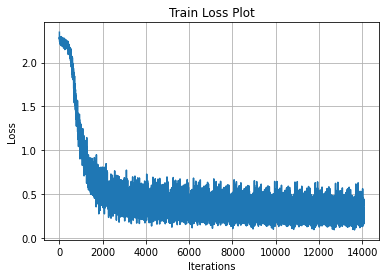

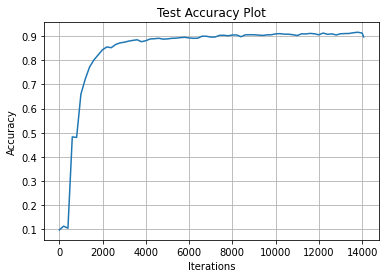

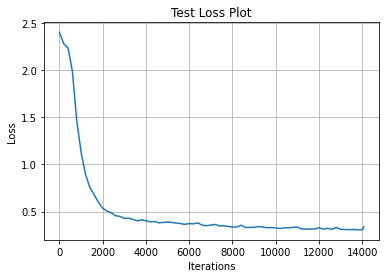

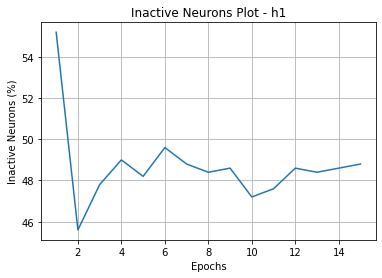

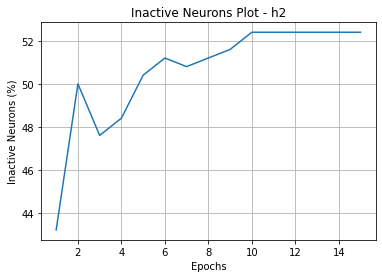

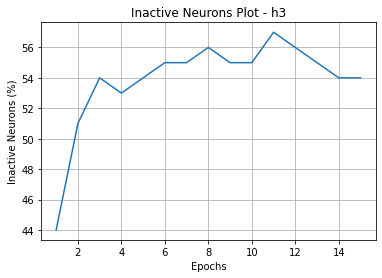

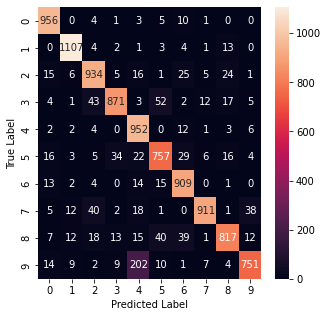

{'F1': 0.8960752890432871,
 'accuracy': 89.64999999999999,
 'conf_mat': array([[ 956,    0,    4,    1,    3,    5,   10,    1,    0,    0],
       [   0, 1107,    4,    2,    1,    3,    4,    1,   13,    0],
       [  15,    6,  934,    5,   16,    1,   25,    5,   24,    1],
       [   4,    1,   43,  871,    3,   52,    2,   12,   17,    5],
       [   2,    2,    4,    0,  952,    0,   12,    1,    3,    6],
       [  16,    3,    5,   34,   22,  757,   29,    6,   16,    4],
       [  13,    2,    4,    0,   14,   15,  909,    0,    1,    0],
       [   5,   12,   40,    2,   18,    1,    0,  911,    1,   38],
       [   7,   12,   18,   13,   15,   40,   39,    1,  817,   12],
       [  14,    9,    2,    9,  202,   10,    1,    7,    4,  751]]),
 'error_rate': 10.350000000000003,
 'precision': 0.9011915753573813,
 'recall': 0.8965}


In [33]:
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/MLP_pics/'
prefix = direc + 'regul-3'
network, report = train(config, data)
# Plotting the relevant graphs of losses and accuracies
plotGraphs(report, config, prefix)

# Calculating relevant metrics
mets = calculateMetrics(report, data, prefix)
pprint.pprint(mets)

# Feature Extraction

In [6]:
# Loading MNIST data onto numpy arrays
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Shuffling data
np.random.seed(0)
train_shuffler = np.random.permutation(60000)
x_train, y_train = x_train[train_shuffler], y_train[train_shuffler]
test_shuffler = np.random.permutation(10000)
x_test, y_test = x_test[test_shuffler], y_test[test_shuffler]

# Froming a dict for convenience
dat = {
    'train':{
        'X':x_train,
        'Y':y_train
    },
    'test':{
        'X':x_test,
        'Y':y_test
    }
}

# lists to hold the extracted features for the images
new_x_train = []
new_x_test = []

for i in tqdm(range(dat['train']['X'].shape[0])):
    fd = hog(dat['train']['X'][i], orientations=9, pixels_per_cell=(5, 5), cells_per_block=(2, 2))
    new_x_train.append(fd)

for i in tqdm(range(dat['test']['X'].shape[0])):
    fd = hog(dat['test']['X'][i], orientations=9, pixels_per_cell=(5, 5), cells_per_block=(2, 2))
    new_x_test.append(fd)

arr_x_tr = np.array(new_x_train)
arr_x_test = np.array(new_x_test)
print(arr_x_test.shape)
print(arr_x_tr.shape)


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

(10000, 576)
(60000, 576)


In [7]:
maxm = max(np.max(arr_x_tr), np.max(arr_x_test))

fe_data = {
    'train':{
        'X':arr_x_tr / maxm,
        'Y':y_train
    },
    'test':{
        'X': arr_x_test / maxm,
        'Y':y_test
    }
}


## MLP

In [44]:
config = {
    'num_epochs' : 8,
    'num_hidden_layers' : 2,
    'hidden_layer_size' : [300,150],
    'weight_decay' : 0,
    'lr' : 1e-1,
    'optimizer' : 'sgd',
    'batch_size' : 64,
    'weights_initializer' : 'xavier_w_only',
    'activation' : 'relu',
}

Input Layer:  576 , Activation: linear
Hidden Layer  1 :  300 , Activation:  relu
Hidden Layer  2 :  150 , Activation:  relu
Output Layer:  10 , Activation: softmax

Training MLP with following configuration:
{'activation': 'relu',
 'batch_size': 64,
 'hidden_layer_size': [300, 150],
 'lr': 0.1,
 'num_epochs': 8,
 'num_hidden_layers': 2,
 'optimizer': 'sgd',
 'weight_decay': 0,
 'weights_initializer': 'xavier_w_only'}


Epoch 1 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8 :


  0%|          | 0/938 [00:00<?, ?it/s]


Final training report:
{'accuracy': 0.9843333333333333,
 'error_rate': 1.5666666666666718,
 'loss': 0.04911429143483808}

Final test report:
{'accuracy': 0.9758,
 'error_rate': 2.42,
 'loss': 0.07061738557386962,
 'pred_labels': array([8, 4, 8, ..., 3, 3, 8])}


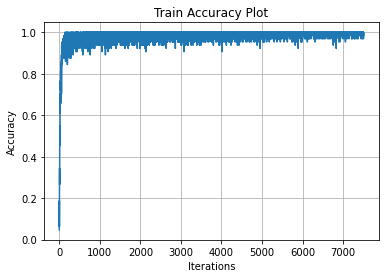

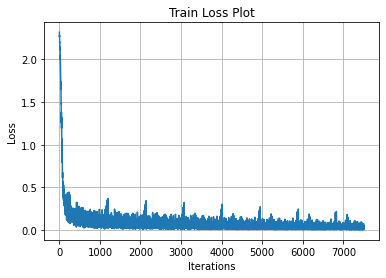

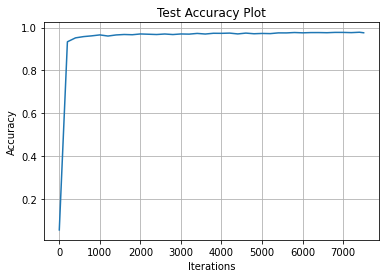

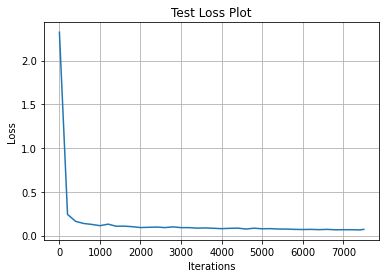

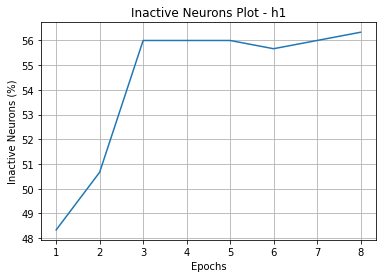

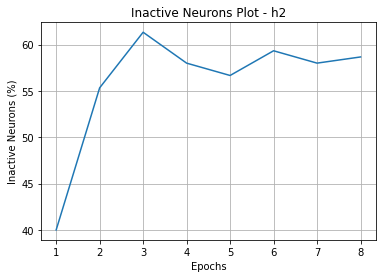

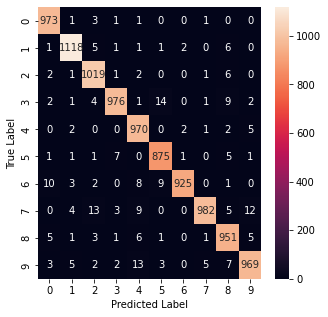

{'F1': 0.9757937370757636,
 'accuracy': 97.58,
 'conf_mat': array([[ 973,    1,    3,    1,    1,    0,    0,    1,    0,    0],
       [   1, 1118,    5,    1,    1,    1,    2,    0,    6,    0],
       [   2,    1, 1019,    1,    2,    0,    0,    1,    6,    0],
       [   2,    1,    4,  976,    1,   14,    0,    1,    9,    2],
       [   0,    2,    0,    0,  970,    0,    2,    1,    2,    5],
       [   1,    1,    1,    7,    0,  875,    1,    0,    5,    1],
       [  10,    3,    2,    0,    8,    9,  925,    0,    1,    0],
       [   0,    4,   13,    3,    9,    0,    0,  982,    5,   12],
       [   5,    1,    3,    1,    6,    1,    0,    1,  951,    5],
       [   3,    5,    2,    2,   13,    3,    0,    5,    7,  969]]),
 'error_rate': 2.42,
 'precision': 0.9760150098558518,
 'recall': 0.9758}


In [45]:
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/MLP_pics/'
prefix = direc + 'fe_mlp'
network, report = train(config, fe_data, 576)
# Plotting the relevant graphs of losses and accuracies
plotGraphs(report, config, prefix)

# Calculating relevant metrics
mets = calculateMetrics(report, fe_data, prefix)
pprint.pprint(mets)

In [26]:
config = {
    'num_epochs' : 8,
    'num_hidden_layers' : 3,
    'hidden_layer_size' : [400,200,100],
    'weight_decay' : 0,
    'lr' : 1e-1,
    'optimizer' : 'sgd',
    'batch_size' : 64,
    'weights_initializer' : 'xavier_w_only',
    'activation' : 'relu',
}

Input Layer:  576 , Activation: linear
Hidden Layer  1 :  400 , Activation:  relu
Hidden Layer  2 :  200 , Activation:  relu
Hidden Layer  3 :  100 , Activation:  relu
Output Layer:  10 , Activation: softmax

Training MLP with following configuration:
{'activation': 'relu',
 'batch_size': 64,
 'hidden_layer_size': [400, 200, 100],
 'lr': 0.1,
 'num_epochs': 8,
 'num_hidden_layers': 3,
 'optimizer': 'sgd',
 'weight_decay': 0,
 'weights_initializer': 'xavier_w_only'}


Epoch 1 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7 :


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8 :


  0%|          | 0/938 [00:00<?, ?it/s]


Final training report:
{'accuracy': 0.99155,
 'error_rate': 0.8449999999999958,
 'loss': 0.026671394484660663}

Final test report:
{'accuracy': 0.9773,
 'error_rate': 2.2700000000000053,
 'loss': 0.06698210313839698,
 'pred_labels': array([8, 4, 8, ..., 3, 3, 8])}


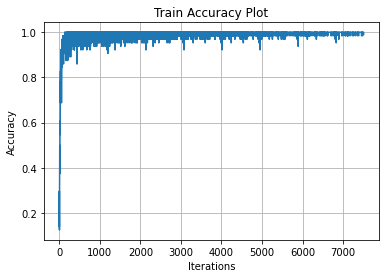

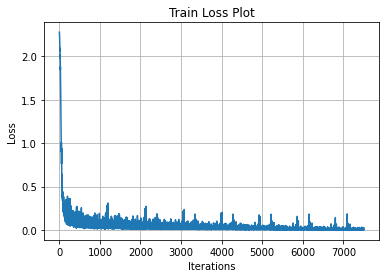

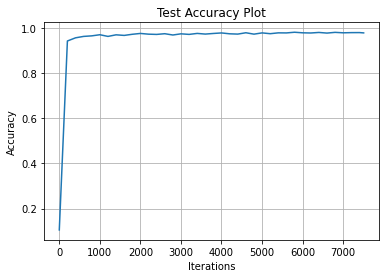

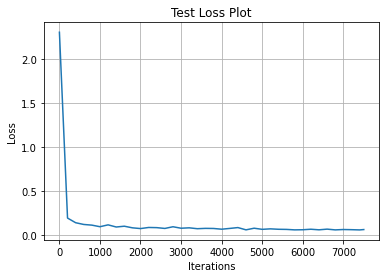

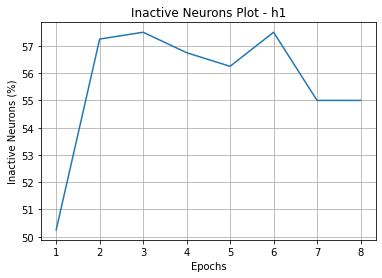

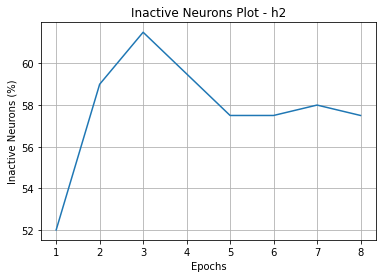

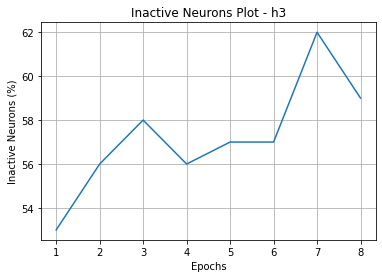

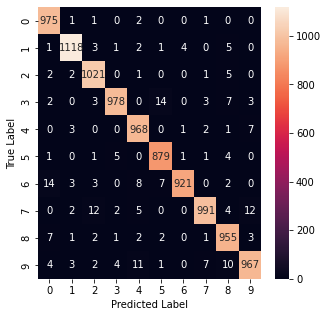

{'F1': 0.9772837723294904,
 'accuracy': 97.72999999999999,
 'conf_mat': array([[ 975,    1,    1,    0,    2,    0,    0,    1,    0,    0],
       [   1, 1118,    3,    1,    2,    1,    4,    0,    5,    0],
       [   2,    2, 1021,    0,    1,    0,    0,    1,    5,    0],
       [   2,    0,    3,  978,    0,   14,    0,    3,    7,    3],
       [   0,    3,    0,    0,  968,    0,    1,    2,    1,    7],
       [   1,    0,    1,    5,    0,  879,    1,    1,    4,    0],
       [  14,    3,    3,    0,    8,    7,  921,    0,    2,    0],
       [   0,    2,   12,    2,    5,    0,    0,  991,    4,   12],
       [   7,    1,    2,    1,    2,    2,    0,    1,  955,    3],
       [   4,    3,    2,    4,   11,    1,    0,    7,   10,  967]]),
 'error_rate': 2.2700000000000053,
 'precision': 0.977456142156261,
 'recall': 0.9773}


In [27]:
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/MLP_pics/'
prefix = direc + 'fe_mlp-2'
network, report = train(config, fe_data, 576)
# Plotting the relevant graphs of losses and accuracies
plotGraphs(report, config, prefix)

# Calculating relevant metrics
mets = calculateMetrics(report, fe_data, prefix)
pprint.pprint(mets)

## KNN



In [46]:
# Even though this can be used, I have made use of the library implementation for potentially more efficient computation

def KNNClassifier(X, y, X_train, y_train, K):
    '''
    This function implements the KNN classifier.
    ####
    ARGUMENTS:
    X[N,...]  - N feature vectors which we need to classify
    y         - Expected class names for X
    Xtr       - Training inputs
    ytr       - Training example labels
    K         - Number of nearest neighbours to consider

    ####
    RETURN:
    Dictionary: Contains
                -- 'pred'      - Array containing the predicted class names for each feature vector in X
                -- 'acc'       - Accuracy of prediction(in %)
    '''

    N = X.shape[0]
    pred = np.zeros((N,))

    for i in tqdm(range(N)):
        dist = np.linalg.norm(X_train-X[i], axis=1)
        K_nearest = y_train[np.argpartition(dist, K)[:K]]
        values, counts = np.unique(K_nearest, return_counts=True)
        pred[i] = values[np.argmax(counts)]

    count = np.sum(np.equal(pred, y))
    acc = 100*count/N

    return {
        'pred': pred,
        'acc': acc
    }

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [10]:
# Taking K to be 5
K = 5

neigh = KNeighborsClassifier(n_neighbors=K)
neigh.fit(fe_data['train']['X'][:10000], fe_data['train']['Y'][:10000])

temp = neigh.predict(fe_data['train']['X'][:10000])
acc_train = 100 * metrics.accuracy_score(fe_data['train']['Y'][:10000], temp)
print(acc_train)

temp = neigh.predict(fe_data['test']['X'][:2000])
acc_test = 100 * metrics.accuracy_score(fe_data['test']['Y'][:2000], temp)
print(acc_test)

# KNN_test = KNNClassifier(fe_data['test']['X'], fe_data['test']['Y'], fe_data['train']['X'], fe_data['train']['Y'], K)
# KNN_train = KNNClassifier(fe_data['train']['X'], fe_data['train']['Y'], fe_data['train']['X'], fe_data['train']['Y'], K)


97.08
96.1


## SVM

In [50]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [51]:
# Takes C to be 1 and uses thee rbf kernel
model = SVC()

# Fitting
model.fit(fe_data['train']['X'], fe_data['train']['Y'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [52]:
# Collecting accuracy values
temp = model.predict(fe_data['test']['X'])
acc_test = 100 * accuracy_score(fe_data['test']['Y'], temp)
print(acc_test)

temp = model.predict(fe_data['train']['X'])
acc_train = 100 * accuracy_score(fe_data['train']['Y'], temp)
print(acc_train)


98.59
99.515


# Sweeps to try various activations and learning rates



In [ ]:
# sweep_config = {
#     'method': 'random'
# }

# parameters_dict = {
#     'optimizer':{'values': 'sgd'},
#         'learning_rate': {
#             'distribution': 'q_log_uniform',
#             'q': 1,
#             'min': np.log(1e-4),
#             'max': np.log(1),
#         },
#         'activation': {'values':['sigmoid', 'relu']},
#     }
    # 'metric': {
    #   'name': 'test_acc',
    #   'goal': 'maximize'
    #  },
# sweep_config['parameters'] = parameters_dict


# sweep configuration
sweep_config = {
    "name": "MLP_sweep2",
    "method": "grid",
    "parameters": {
        "lr": {"values": [1,1e-1,1e-2,1e-3]},
        "num_epochs" : {"value": 15},
        "num_hidden_layers" : {"value": 3},
        "weight_decay" : {"value": 0},
        "optimizer" : {"value": "sgd"},
        "batch_size" : {"value": 64},
        "weights_initializer" : {"value": "xavier_w_only"},
        "activation": {"value": "sigmoid"}        
    }
}

pprint.pprint(sweep_config)

In [25]:
sweep_id = wandb.sweep(sweep_config, project="EE6132_Lab1")

Create sweep with ID: g159vo2x
Sweep URL: https://wandb.ai/ani_r/EE6132_Lab1/sweeps/g159vo2x


In [ ]:
# def sweep_train(config=None):
#     '''
#     Training the model according to our required specifications mentioned in config
#     '''
    
#     # Setting the MLP shape
#     nn_shape = setNNShape(config['num_hidden_layers'], [500,250,100], config['activation'])
        
#     # Declaring MLP of appropriate shape and initializing its weights and biases
#     network = NeuralNetwork(nn_shape, config['weights_initializer'])
        
#     # calling the optimizer
#     report = getattr(optimizer, config['optimizer'])(network, data, config)

#     return network, report

def sweep_train(config):
    '''
    Training the model according to our required specifications mentioned in config
    '''
    # Training the work defined by config
    with wandb.init(config):
        # making a local copy of config
        config = wandb.config

        #overwriting run name
        wandb.run.name = 'ac:'+config['activation'][:3]+'_lr:'+str(config['lr'])+'_hl:'+str(config['num_hidden_layers'])+':'+str([500,250,100])+'_ep:'+str(config['num_epochs'])

        # Setting the MLP shape
        nn_shape = setNNShape(config['num_hidden_layers'], [500,250,100], config['activation'])
            
        # Declaring MLP of appropriate shape and initializing its weights and biases
        network = NeuralNetwork(nn_shape, config['weights_initializer'])
            
        # calling the optimizer
        report = getattr(optimizer, config['optimizer'])(network, data, config)

        # plotGraphs(report)


In [ ]:
# performing the sweep
wandb.agent(sweep_id, sweep_train)

# Rough Work

In [ ]:
data = load_mnist(10000, False, True, 0)
print(data.keys())
print(data['train']['X'].shape)
print(data['train']['y'].shape)
print(data['val']['X'].shape)
print(data['val']['y'].shape)
print(data['test']['X'].shape)
print(data['test']['y'].shape)

In [ ]:
def relu(z):
    return np.maximum(z, 0)

print(relu(-2))
print(relu(-1))
print(relu(0))
print(relu(0.001))
print(relu(2))
print(relu(np.array([[1,0], [-1000, 100]])))

In [33]:
def plotGraphs(report):
    acc = report['accuracies']
    loss = report['losses']
    acc_test = report['accuracies_test']
    loss_test = report['losses_test']

    len_train = len(acc)

    plt.figure()
    plt.plot(np.arange(1, len_train+1), acc)
    plt.grid()
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy (%)')
    plt.title('Train')
    wandb.log({"Accuracy v iter": plt})
    plt.show()

    plt.figure()
    plt.plot(np.arange(1, len_train+1), loss)
    plt.grid()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Train')
    wandb.log({"Loss v iter": plt})
    plt.show()


    plt.figure()
    plt.plot(list(np.arange(1, len_train-1, 200)) + [len_train], acc_test)
    plt.grid()
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy (%)')
    plt.title('Test')
    wandb.log({"Accuracy v iter(test)": plt})
    plt.show()

    plt.figure()
    plt.plot(list(np.arange(1, len_train-1, 200)) + [len_train], loss_test)
    plt.grid()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Test')
    wandb.log({"Loss v iter(test)": plt})
    plt.show()

In [ ]:
# sweep configuration
sweep_config = {
    "name": "test_sweep",
    "method": "grid",
    "parameters": {
        "lr": {"values": [1e-1,1e-2]},
        "num_epochs" : {"value": 3},
        "num_hidden_layers" : {"value": 2},
        "weight_decay" : {"value": 0},
        "optimizer" : {"value": "sgd"},
        "batch_size" : {"value": 128},
        "weights_initializer" : {"value": "xavier_w_only"},
        "activation": {"value": "relu"}        
    }
}

pprint.pprint(sweep_config)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="EE6132_Lab1")

In [61]:
def sweep_train(config=None):
    '''
    Training the model according to our required specifications mentioned in config
    '''
    # Training the work defined by config
    with wandb.init(config):
        # making a local copy of config
        config = wandb.config

        #overwriting run name
        wandb.run.name = 'fake_ac:'+config['activation'][:3]+'_lr:'+str(config['lr'])+'_hl:'+str(config['num_hidden_layers'])+':'+str([250,100])+'_ep:'+str(config['num_epochs'])

        # Setting the MLP shape
        nn_shape = setNNShape(config['num_hidden_layers'], [250,100], config['activation'])
            
        # Declaring MLP of appropriate shape and initializing its weights and biases
        network = NeuralNetwork(nn_shape, config['weights_initializer'])
            
        # calling the optimizer
        report = getattr(optimizer, config['optimizer'])(network, data, config)

        plotGraphs(report)


In [ ]:
# performing the sweep
wandb.agent(sweep_id, sweep_train)

In [ ]:
# def train(config):
#     '''
#     Training the model according to our required specifications mentioned in config
#     '''
    
#     # Setting the MLP shape
#     nn_shape = setNNShape(config['num_hidden_layers'], config['hidden_layer_size'], config['activation'])
        
#     # Declaring MLP of appropriate shape and initializing its weights and biases
#     network = NeuralNetwork(nn_shape, config['weights_initializer'])
        
#     # calling the optimizer
#     report = getattr(optimizer, config['optimizer'])(network, data, config)

#     return network, report

In [19]:
config = {
    'num_epochs' : 5,
    'num_hidden_layers' : 2,
    'hidden_layer_size' : [200, 100],
    'weight_decay' : 0,
    'lr' : 1e-1,
    'optimizer' : 'sgd',
    'batch_size' : 128,
    'weights_initializer' : 'xavier_w_only',
    'activation' : 'relu'
}

In [ ]:
prefix = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/MLP_pics/fakeee'
network, report = train(config, data)
# Plotting the relevant graphs of losses and accuracies
plotGraphs(report, config, prefix)

# Calculating relevant metrics
mets = calculateMetrics(report, data, prefix)
print(mets)

In [53]:
print('akjdkdn%s'%(1e-3))

akjdkdn0.001
